# Data Analysis
[Check here](#Here)

# Basic imports

In [3]:
# basic python
import os
import re
import sys
import copy
import json
import warnings
from collections import namedtuple

### data analysis
import numpy as np
import pandas as pd
from scipy.stats import gmean

# compositional data analysis
import skbio.stats.composition as coda

### plotting
# matplotlib & seaborn
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages # PDF generation
from matplotlib.patches import Ellipse

import seaborn as sns

# plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

### utils
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

### figthing imbalance
from imblearn.over_sampling import SMOTENC

### Imports for machine learning algorithms 
### will be imported in the appropriate sections of this notebook

In [4]:
sns.set_theme(palette='colorblind', style='ticks')

In [5]:
warnings.filterwarnings('ignore')

# Functions

In [7]:
def plot_confidence_ellipse(ax, data, n_std=2.0, facecolor='none', **kwargs):
   
    if data.shape[0] < 2:
        return

    cov = np.cov(data.T)
    mean = np.mean(data, axis=0)

    # Eigenvectors and eigenvalues (rotation and scale of ellipse)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]

    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)

    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                      facecolor=facecolor, **kwargs)
    ax.add_patch(ellipse)

In [8]:
def ellipses_95_confidence(x, y, data, group_col, palette, group_order=None, ax=None):

    if group_order:
        groups = group_order
    else:
        groups = data[group_col].unique().tolist()
    
    for group_name, color in zip(groups, palette):
        group_df = data[data['Locality'] == group_name]
        points = group_df[[x, y]].values
        
        if ax is None:
            ax = plt.gca()
        
        plot_confidence_ellipse(ax, points, edgecolor=color, n_std=2)

In [9]:
def sample_prediction(test_y, pred_y, index_label=['SampleID', 'Line']):
    
    df = pd.DataFrame()
    
    df['Value'] = test_y
    df['Prediction'] = pred_y
    df['PredictionAccuracy'] = df.Value == df.Prediction
    
    pred_acc = df['PredictionAccuracy'].groupby(index_label).sum() / df['PredictionAccuracy'].groupby(index_label).count()
    
    return pred_acc

In [10]:
def grid_results_view(grid):
    
    res = pd.DataFrame(grid.cv_results_)
    res.dropna(subset=['split0_test_score', 'std_test_score'], inplace=True)
    res.sort_values("rank_test_score", inplace=True)
    
    return res

In [11]:
def prediction_accuracy_frame(test_y, pred_y, index_label=['SampleID', 'Line']):
    
    pred_y = pd.Series(pred_y, index=test_y.index)
    pred_mode = pred_y.groupby(index_label).agg(pd.Series.mode)
    pred_mode.rename('PredictionMode', inplace=True)

    pred_acc = sample_prediction(test_y, pred_y, index_label=index_label)
    
    pred_results_frame = pd.concat([test_y.groupby(index_label).max(), pred_mode, pred_acc], axis=1)
    
    return pred_results_frame

In [12]:
def models_feats(zeros_to_nan=False, **models):
    feat_frame = pd.DataFrame()
    
    for name, model in models.items():
        keys = model.feature_names_in_
        
        if hasattr(model, 'coef_'):
            values = np.abs(model.coef_).sum(axis=0) / np.abs(model.coef_).sum()
            
        elif hasattr(model, 'feature_importances_'):
            values = model.feature_importances_
        
        else:
            raise TypeError('the model must have `coef_` or `feature_importances_` attribute')
        
        feats_vals = dict( zip ( keys, values ) )
        
        feat_frame[name] = feats_vals
    if zeros_to_nan:
        feat_frame = feat_frame.replace(0, np.nan)
        
    return feat_frame

In [13]:
def model_predictions(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    predframe = prediction_accuracy_frame(y_test, y_pred)
    return y_pred, acc_score, predframe

In [14]:
def acc_meas(y_test, y_pred, print_res=True, return_vals=False):
    accu = accuracy_score(y_test, y_pred)
    f1_wgt = f1_score(y_test, y_pred, average='weighted')
    f1_mic = f1_score(y_test, y_pred, average='micro')
    
    if print_res:
        print('accuracy score:    {}'.format(accu))
        print('f1 weighted score: {}'.format(f1_wgt))
        print('f1 micro score:    {}'.format(f1_mic))
    
    if return_vals:
        res = {
            'accuracy' : accu,
            'f1_weighted' : f1_wgt,
            'f1_micro' : f1_mic
        }
        return res

In [15]:
def prob_classes(X, model, precision=4):
    prediction = model.predict_proba(X)
    prob_frame = pd.DataFrame(prediction, index=X.index, columns=model.classes_)
    if precision:
        prob_frame = prob_frame.round(precision)
        
    return prob_frame

In [16]:
def fast_conf_hmap(data, title, ticks, ax, pred=True):
    
    sns.heatmap(data=data, cmap=plt.cm.seismic, annot=True,
                cbar=False, square=True, linewidths=0.5, 
                xticklabels=ticks, yticklabels=ticks, ax=ax)
    ax.set_title(title)
    
    if pred:
        txt = 'Locality'
    else:
        txt = 'Bone'
    
    ax.set(xlabel='Predicted '+txt, ylabel='True '+txt)
    
    return ax

In [17]:
def confusion_hmap(conf_mat, labels, cbar=False, cmap='seismic'):
    
    ax = sns.heatmap(data=conf_mat, cmap=cmap, annot=True, cbar=cbar, square=True,
                     linewidths=0.5, xticklabels=labels, yticklabels=labels)
    plt.yticks(rotation=0)

    return ax

In [18]:
def plot_misclass(data, missclass_col, element, ymin=0, **kwargs):
    fg = sns.relplot(ppmData, x='mmDist', y=element, row='SampleID', hue=missclass_col, 
                    palette=['darkred', 'forestgreen'], height=3, aspect=2, **kwargs).set(yscale='log')

    misclass = data.loc[~data[missclass_col], 'mmDist']
    
    for name, ax in fg.axes_dict.items():
        try:
            samp = misclass.loc[[name]]
        except:
            continue
        for spot_id, spot_x in samp.items():
            ax.vlines(x=spot_x, ymin=ymin, ymax=ppmData.loc[spot_id, element], color='firebrick', ls=':')
    return fg

In [19]:
joinlocs = lambda df: df.merge(localities, on=['SampleID', 'Line', 'Spot'])

In [20]:
loadframe = lambda x: pd.read_excel(x + '.xlsx', index_col=[0, 1, 2])

In [21]:
# acc_dict = lambda acc : dict(zip(['accuracy', 'f1 weighted', 'f1 micro'], acc))

In [22]:
acc_frame = lambda acc : pd.DataFrame(acc).T.sort_values('f1_weighted', ascending=False)

In [23]:
idx = pd.IndexSlice

In [24]:
loadcsv = lambda file : pd.read_csv('Data/' + file, sep=';', index_col=[0, 1, 2, 3])

In [25]:
rareEarthsYttr = ["La", "Ce", "Pr", "Nd", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Y", "Er", "Tm", "Yb", "Lu"]

# Read and prepare frames

**Read the DataFrames**

In [28]:
ppm = loadcsv('ppmLODsfill.csv')
err = loadcsv('err.csv')
spot_info = loadcsv('spot_fullinfo.csv')

In [29]:
thin_sections = pd.read_csv('Data/ThinSections.csv', sep=';')

In [30]:
localities = spot_info.loc[:, 'Locality']
bones = spot_info.loc[:, 'Bone']

Fill the zeros

In [32]:
repl_dict = {}

for column in ppm.columns:
    ser = ppm[column]
    ser_larger_than_0 = ser[ser > 0]
    minimum_val = ser_larger_than_0.min()
    replacement = minimum_val / 10
    repl_dict[column] = { 0 : replacement}

In [33]:
ppm = ppm.replace(repl_dict)

In [34]:
repl_dict

{'Ca': {0: 35999.99999999999},
 'V': {0: 0.5175472157468185},
 'Mn': {0: 1.0699344217968856},
 'Fe': {0: 0.22166393539760088},
 'Cu': {0: 0.0046744081724303405},
 'Zn': {0: 0.1288621654150375},
 'Ga': {0: 0.01149902531403442},
 'Rb': {0: 2.537980793229117e-13},
 'Sr': {0: 71.22301609764018},
 'Y': {0: 0.01339330084244888},
 'Ba': {0: 1.8474736064411297},
 'La': {0: 2.384720059213e-05},
 'Ce': {0: 1.6849375694007476e-13},
 'Pr': {0: 4.555381339288372e-13},
 'Nd': {0: 8.655193179308637e-26},
 'Sm': {0: 2.3887052197041124e-13},
 'Eu': {0: 5.998477177869666e-10},
 'Gd': {0: 2.670578526905748e-14},
 'Tb': {0: 3.361807696952699e-13},
 'Dy': {0: 2.4755713924940002e-05},
 'Ho': {0: 0.00025886652323455},
 'Er': {0: 0.0009265545464451901},
 'Tm': {0: 5.398618286150615e-30},
 'Yb': {0: 0.00228497281169085},
 'Lu': {0: 0.0008665133348934901},
 'Hf': {0: 1.5952624504640692e-13},
 'Th': {0: 1.0039095443120083e-09},
 'U': {0: 1.7624775346119137}}

In [35]:
ppm_closed = coda.closure(ppm)

In [36]:
alr_data = pd.DataFrame(
    data=coda.alr(ppm_closed),
    index=ppm.index,
    columns=ppm.columns[1:]
)

In [37]:
clr_data = pd.DataFrame(
    data=coda.clr(ppm_closed),
    index=ppm.index,
    columns=ppm.columns
)

In [38]:
ppm_nofills = loadcsv('ppm.csv')

In [39]:
idx = pd.IndexSlice

In [40]:
train_longbones_samples = ['PR003', 'SF001', 'SF002', 'TS011', 'TS013', 'TS025', 'TS031', 'TS018', 'TS016', 'TS017']
test_longbones_samples = ['PR006', 'TS012', 'TS029', 'TS020', 'TS021', 'TS030']

alr_train = alr_data.loc[idx[train_longbones_samples], :]
alr_test = alr_data.loc[idx[test_longbones_samples], :]

clr_train = clr_data.loc[idx[train_longbones_samples], :]
clr_test = clr_data.loc[idx[test_longbones_samples], :]

locs_train = localities.loc[idx[train_longbones_samples], :]
locs_test = localities.loc[idx[test_longbones_samples], :]

bones_train = bones.loc[idx[train_longbones_samples], :]
bones_test = bones.loc[idx[test_longbones_samples], :]

In [41]:
train_ribs = ['TF029', 'TS015', 'PR002', 'TF028', 'TF006']
test_ribs = ['TS027', 'TS026', 'SF003', 'PR001', 'TS024', 'TS022']

In [42]:
ribs_train = alr_data.loc[idx[train_ribs], :]
ribs_test = alr_data.loc[idx[test_ribs], :]

locs_ribs_train = localities.loc[idx[train_ribs], :]
locs_ribs_test = localities.loc[idx[test_ribs], :]

# Machine Learning Models

In [44]:
# machine learning

### preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

### model selection 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold, GroupKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, validation_curve

### selecting features
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LassoCV

### accuracy
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay

In [45]:
ppm_long = ppm_nofills.melt(ignore_index=False, var_name='Element', value_name='PPM').merge(spot_info, left_index=True, right_index=True).reset_index()

In [46]:
ppm_long = ppm_long[ppm_long.Element != 'Ca']

In [47]:
ppm_summary = ppm_long.groupby(['Locality', 'Element']).describe()['PPM']
ppm_summary.to_excel('Describe.xlsx', merge_cells=False)

In [48]:
ppm_info = ppm.merge(spot_info[['Locality', 'Bone']], left_index=True, right_index=True)

In [49]:
ppm_locs_group = ppm_info.groupby('Locality')
summaries = {}

for group in ['Toogreek', 'Nemegt', 'Altan Uul', 'Tsagan Khushuu', 'Bayan Dzak']:

    # frame for locality
    df = ppm_locs_group.get_group(group).iloc[:, :-2]

    # compositional centers
    centers = pd.Series( coda.clr_inv( np.mean( coda.clr( coda.closure( df.replace(0, 0.00001) ) ), axis=0 ) ), index=df.columns )
    centers_norm = ( 360_000 / centers['Ca'] ) * centers # normalize to Ca = 360_000 ppm

    # summary
    descr = df.describe()
    descr.loc['center', :] = centers_norm
    descr = descr.T.drop(columns='count', index='Ca').rename(columns={'50%' : 'median', '25%' : 'q_25', '75%' : 'q_75'})

    summaries[group] = descr

summaries_locs = pd.concat(summaries)

In [50]:
ppm_bones_group = ppm_info.groupby('Bone')
summaries = {}

for group in ['rib', 'metatarsal', 'tibia', 'femur', 'humerus', 'radius']:

    # frame for locality
    df = ppm_bones_group.get_group(group).iloc[:, :-2]

    # compositional centers
    centers = pd.Series( coda.clr_inv( np.mean( coda.clr( coda.closure( df.replace(0, 0.00001) ) ), axis=0 ) ), index=df.columns )
    centers_norm = ( 360_000 / centers['Ca'] ) * centers # normalize to Ca = 360_000 ppm

    # summary
    descr = df.describe()
    descr.loc['center', :] = centers_norm
    descr = descr.T.drop(columns='count', index='Ca').rename(columns={'50%' : 'median', '25%' : 'q_25', '75%' : 'q_75'})

    summaries[group] = descr

summaries_bones = pd.concat(summaries)

In [51]:
with pd.ExcelWriter('Data/Data description.xlsx') as writer:
    summaries_locs.to_excel(writer, sheet_name='Localities', merge_cells=False)
    summaries_bones.to_excel(writer, sheet_name='Bones', merge_cells=False)

In [52]:
ppmData = ppm.merge(spot_info, left_index=True, right_index=True)

## LDA

In [54]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [55]:
lda = LDA(n_components=3)

In [56]:
lda_train = lda.fit_transform(clr_data, localities)

In [57]:
data_lda = pd.DataFrame(
    data=lda_train,
    index=clr_data.index,
    columns=['LDA' + str(i) for i in range(1, 4)]
    # columns=['LDA1', 'LDA2', 'LDA3']
)

In [58]:
pd.DataFrame(
    data=lda.scalings_,
    index=clr_data.columns,
    columns=[f'LDA{i+1}' for i in range(4)]
)

,LDA1,LDA2,LDA3,LDA4
Ca,1.828346,2.255868,2.285789,3.174010
V,-0.115742,-0.762775,0.547699,0.421680
Mn,1.143745,0.178517,0.665488,-0.259377
Fe,0.431605,0.327294,-0.462117,-0.018141
Cu,-0.535863,0.008408,0.391390,0.274237
Zn,0.160286,0.607267,-0.919107,0.138704
Ga,-0.676885,0.027117,-0.287299,-0.023946
Rb,0.014931,0.038187,-0.021722,-0.040857
Sr,-2.378208,-1.860260,-0.728754,-3.228042
Y,-0.572577,0.627134,-1.841578,-3.933352


In [59]:
lda.explained_variance_ratio_

array([0.61984935, 0.17461535, 0.1404038 ])

In [60]:
data_lda = data_lda.merge(spot_info, left_index=True, right_index=True)

In [61]:
pd.DataFrame(
    data=lda.coef_, 
    columns=lda.feature_names_in_,
    index=lda.classes_
).to_csv('Data/LDA coefficients.csv', sep=';')

In [62]:
np.cumsum(lda.explained_variance_ratio_)

array([0.61984935, 0.7944647 , 0.9348685 ])

In [63]:
lda_scalings = pd.DataFrame(data=lda.scalings_,
                            index=clr_data.columns,
                            columns=[f'LDA{i+1}' for i in range(lda.scalings_.shape[1])])

In [64]:
lda_scalings.to_csv('LDA scalings.csv', sep=';')

In [65]:
trab_bones = data_lda[data_lda.Bone.isin(['rib', 'metatarsal', 'frill', 'vertebra', 'tooth'])]
long_bones = data_lda[~data_lda.Bone.isin(['rib', 'metatarsal', 'frill', 'vertebra', 'tooth'])]

In [66]:
data = long_bones.loc[:, 'LDA1':'LDA3']

In [67]:
lda.explained_variance_ratio_

array([0.61984935, 0.17461535, 0.1404038 ])

In [68]:
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

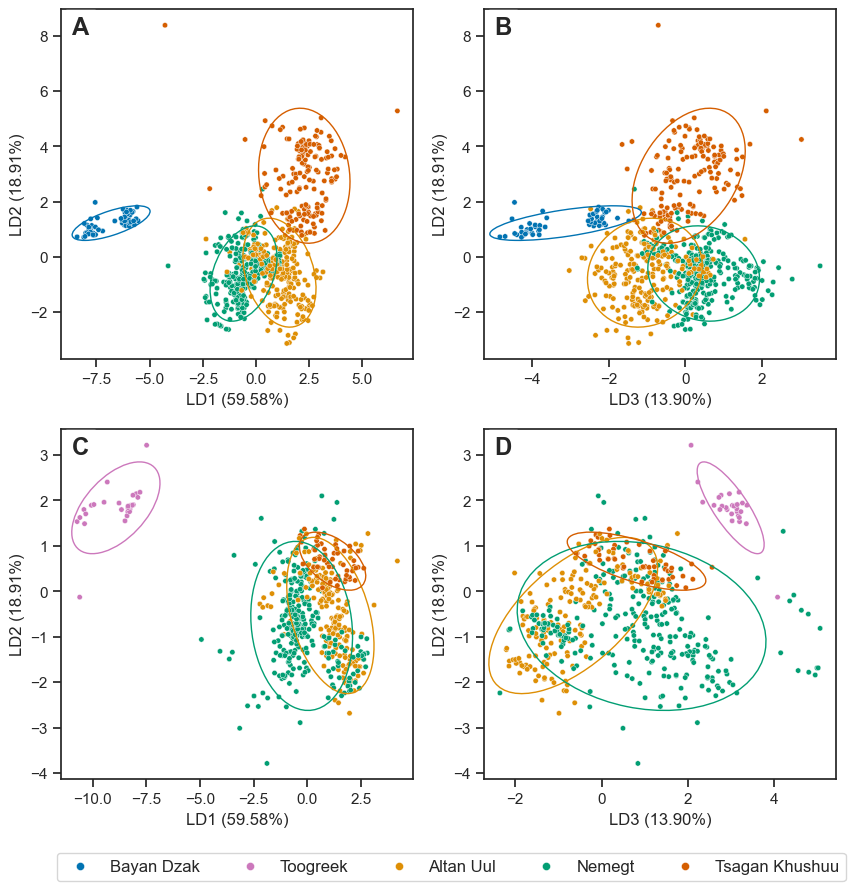

In [69]:
sns.set_theme(context='notebook', palette='dark', style='ticks')

order_locs_1 = ['Bayan Dzak', 'Altan Uul', 'Nemegt', 'Tsagan Khushuu']
order_locs_2 = ['Toogreek', 'Altan Uul', 'Nemegt', 'Tsagan Khushuu']

dark_palette1 = np.array(sns.color_palette('colorblind'))[0:4].tolist()
dark_palette2 = np.array(sns.color_palette('colorblind'))[[4, 1, 2, 3]].tolist()

tick_labels = {
    'LDA1' : 'LD1 (59.58%)', 
    'LDA2' : 'LD2 (18.91%)', 
    'LDA3' : 'LD3 (13.90%)'
}

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax00 = sns.scatterplot(long_bones, x='LDA1', y='LDA2', hue='Locality', s=15, ax=ax[0, 0], hue_order=order_locs_1, palette=dark_palette1)
ellipses_95_confidence('LDA1', 'LDA2', long_bones, 'Locality', dark_palette1, group_order=order_locs_1, ax=ax00)
ax00.set_xlabel(tick_labels['LDA1'])
ax00.set_ylabel(tick_labels['LDA2'])
ax00.legend().set_visible(False)

ax01 = sns.scatterplot(long_bones, x='LDA3', y='LDA2', hue='Locality', s=15, ax=ax[0, 1], hue_order=order_locs_1, legend=False, palette=dark_palette1)
ellipses_95_confidence('LDA3', 'LDA2', long_bones, 'Locality', dark_palette1, group_order=order_locs_1, ax=ax[0,1])
ax01.set_xlabel(tick_labels['LDA3'])
ax01.set_ylabel(tick_labels['LDA2'])

ax10 = sns.scatterplot(trab_bones, x='LDA1', y='LDA2', hue='Locality', s=15, ax=ax[1, 0], hue_order=order_locs_2, palette=dark_palette2)
ellipses_95_confidence('LDA1', 'LDA2', trab_bones, 'Locality', dark_palette2, group_order=order_locs_2, ax=ax[1,0])
ax10.set_xlabel(tick_labels['LDA1'])
ax10.set_ylabel(tick_labels['LDA2'])
ax10.legend().set_visible(False)

ax11 = sns.scatterplot(trab_bones, x='LDA3', y='LDA2', hue='Locality', s=15, ax=ax[1, 1], hue_order=order_locs_2, legend=False, palette=dark_palette2)
ellipses_95_confidence('LDA3', 'LDA2', trab_bones, 'Locality', dark_palette2, group_order=order_locs_2, ax=ax[1,1])
ax11.set_xlabel(tick_labels['LDA3'])
ax11.set_ylabel(tick_labels['LDA2'])

handAB, labAB = ax00.get_legend_handles_labels()
handCD, labCD = ax10.get_legend_handles_labels()

handles = [handAB[0]] + handCD
labels = [labAB[0]] + labCD

fig.legend(handles, labels, fontsize='medium', title_fontsize='x-large', loc='lower center', markerscale=1.5, ncols=5, bbox_to_anchor=(0.515, 0.0))

for num, axs in zip(["A", "B", "C", "D"], ax.flat):
    axs.text(0.03, 0.93, str(num), transform=axs.transAxes, bbox=dict(facecolor='white'), fontsize='x-large', fontweight='bold')

fig.savefig('Plots/LDA separation.png', dpi=300, bbox_inches='tight')

## Logistic Regression

In [71]:
from sklearn.linear_model import LogisticRegression

In [72]:
logreg = LogisticRegression(class_weight='balanced')

In [73]:
logreg.fit(alr_train, locs_train)

LogisticRegression(class_weight='balanced')

In [74]:
locs_pred = logreg.predict(alr_test)

In [75]:
acc_meas(locs_test, locs_pred)

accuracy score:    0.5670498084291188
f1 weighted score: 0.5709751917701132
f1 micro score:    0.5670498084291188


In [76]:
prediction_accuracy_frame(locs_test, locs_pred)

Locality PredictionMode  PredictionAccuracy
SampleID Line                                                   
PR006    L1        Bayan Dzak     Bayan Dzak            1.000000
         L2        Bayan Dzak     Bayan Dzak            1.000000
         L3        Bayan Dzak     Bayan Dzak            1.000000
TS012    L1         Altan Uul      Altan Uul            1.000000
TS020    L1            Nemegt         Nemegt            0.976744
TS021    L1         Altan Uul         Nemegt            0.057143
TS029    L1            Nemegt      Altan Uul            0.188679
TS030    L1    Tsagan Khushuu      Altan Uul            0.480769
         L2    Tsagan Khushuu      Altan Uul            0.250000

### Logistic Regression Model Selection - Long Bones

In [78]:
lr_params = {
    'C' : [0.01, 0.1, 1., 10], #np.logspace(-2, 2, 7),
    'multi_class' : ['ovr', 'multinomial'],
    'solver' : ['liblinear', 'saga', 'lbfgs', 'newton-cg', 'sag', 'newton-cholesky'],
    'penalty' : ['l2']#, 'l2']
}

In [79]:
samples = clr_train.index.get_level_values(0).to_numpy()

In [80]:
logreg_grid = GridSearchCV(LogisticRegression(random_state=13, class_weight='balanced'), param_grid=lr_params, cv=3, n_jobs=-1)

In [81]:
logreg_grid.fit(clr_train, locs_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=13),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1.0, 10],
                         'multi_class': ['ovr', 'multinomial'],
                         'penalty': ['l2'],
                         'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg',
                                    'sag', 'newton-cholesky']})

In [82]:
sorted_grid_logreg = grid_results_view(logreg_grid)

In [83]:
sorted_grid_logreg

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_multi_class,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
41,0.030290,0.004779,0.002336,9.430808e-04,10.00,ovr,l2,newton-cholesky,"{'C': 10, 'multi_class': 'ovr', 'penalty': 'l2...",0.682635,0.964072,0.867470,0.838059,0.116763,1
39,0.058746,0.022021,0.001999,2.973602e-07,10.00,ovr,l2,newton-cg,"{'C': 10, 'multi_class': 'ovr', 'penalty': 'l2...",0.682635,0.964072,0.867470,0.838059,0.116763,1
38,0.054463,0.006951,0.002668,4.717637e-04,10.00,ovr,l2,lbfgs,"{'C': 10, 'multi_class': 'ovr', 'penalty': 'l2...",0.682635,0.916168,0.903614,0.834139,0.107252,3
44,0.034864,0.006547,0.002434,4.172106e-04,10.00,multinomial,l2,lbfgs,"{'C': 10, 'multi_class': 'multinomial', 'penal...",0.682635,0.922156,0.891566,0.832119,0.106436,4
36,0.014337,0.001249,0.002332,4.705838e-04,10.00,ovr,l2,liblinear,"{'C': 10, 'multi_class': 'ovr', 'penalty': 'l2...",0.682635,0.916168,0.879518,0.826107,0.102547,5
26,0.074018,0.003744,0.002666,9.435838e-04,1.00,ovr,l2,lbfgs,"{'C': 1.0, 'multi_class': 'ovr', 'penalty': 'l...",0.682635,0.928144,0.843373,0.818051,0.101816,6
45,0.052215,0.031002,0.001667,4.718206e-04,10.00,multinomial,l2,newton-cg,"{'C': 10, 'multi_class': 'multinomial', 'penal...",0.682635,0.940120,0.825301,0.816019,0.105323,7
24,0.012001,0.000818,0.002668,4.735628e-04,1.00,ovr,l2,liblinear,"{'C': 1.0, 'multi_class': 'ovr', 'penalty': 'l...",0.682635,0.916168,0.843373,0.814059,0.097567,8
29,0.035342,0.007544,0.003001,4.052337e-07,1.00,ovr,l2,newton-cholesky,"{'C': 1.0, 'multi_class': 'ovr', 'penalty': 'l...",0.682635,0.928144,0.813253,0.808010,0.100297,9
27,0.057346,0.005558,0.003001,8.173136e-04,1.00,ovr,l2,newton-cg,"{'C': 1.0, 'multi_class': 'ovr', 'penalty': 'l...",0.682635,0.928144,0.813253,0.808010,0.100297,9


In [84]:
logreg_bparams = sorted_grid_logreg.iloc[0]['params']

### Best Logistic Regression

In [86]:
logreg_best = LogisticRegression(**logreg_bparams, random_state=13, class_weight='balanced') #, class_weight='balanced')

In [87]:
logreg_best.fit(alr_train, locs_train)

LogisticRegression(C=10, class_weight='balanced', multi_class='ovr',
                   random_state=13, solver='newton-cholesky')

In [88]:
# locs_pred = logreg.predict(alr_test)
locs_pred = logreg_best.predict(alr_test)

In [89]:
logreg_acc = acc_meas(locs_test, locs_pred, return_vals=True)

accuracy score:    0.5095785440613027
f1 weighted score: 0.5126442783203219
f1 micro score:    0.5095785440613027


In [90]:
logreg_predframe = prediction_accuracy_frame(locs_test, locs_pred)
display(logreg_predframe)

Locality PredictionMode  PredictionAccuracy
SampleID Line                                                   
PR006    L1        Bayan Dzak     Bayan Dzak            1.000000
         L2        Bayan Dzak     Bayan Dzak            1.000000
         L3        Bayan Dzak     Bayan Dzak            1.000000
TS012    L1         Altan Uul      Altan Uul            1.000000
TS020    L1            Nemegt         Nemegt            0.976744
TS021    L1         Altan Uul         Nemegt            0.057143
TS029    L1            Nemegt      Altan Uul            0.000000
TS030    L1    Tsagan Khushuu      Altan Uul            0.442308
         L2    Tsagan Khushuu      Altan Uul            0.000000

### Logistic Regression - Other bones - Hyperparameters

In [92]:
lr_params = {
    'C' : [0.001, 0.01], #np.logspace(-2, 2, 7),
    'multi_class' : ['ovr', 'multinomial'],
    'solver' : ['liblinear', 'saga', 'lbfgs', 'newton-cg', 'sag', 'newton-cholesky'],
    'penalty' : ['l2']#, 'l2']
}

In [93]:
logreg_grid = GridSearchCV(LogisticRegression(random_state=13, class_weight='balanced'), param_grid=lr_params, cv=3, n_jobs=-1) #GroupKFold(n_splits=2)

In [94]:
logreg_grid.fit(ribs_train, locs_ribs_train)#, groups=bones.loc[alr_train.index])

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=13),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01],
                         'multi_class': ['ovr', 'multinomial'],
                         'penalty': ['l2'],
                         'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg',
                                    'sag', 'newton-cholesky']})

In [95]:
sorted_grid_logreg = grid_results_view(logreg_grid)

In [96]:
sorted_grid_logreg

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_multi_class,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
12,0.008001,0.001415,0.002666,0.000472,0.010,ovr,l2,liblinear,"{'C': 0.01, 'multi_class': 'ovr', 'penalty': '...",0.601852,0.962963,0.490741,0.685185,0.201588,1
19,0.026684,0.002246,0.003667,0.000472,0.010,multinomial,l2,saga,"{'C': 0.01, 'multi_class': 'multinomial', 'pen...",0.601852,0.870370,0.546296,0.672840,0.141505,2
22,0.028670,0.002625,0.003671,0.000471,0.010,multinomial,l2,sag,"{'C': 0.01, 'multi_class': 'multinomial', 'pen...",0.601852,0.870370,0.537037,0.669753,0.144305,3
16,0.055031,0.009754,0.002668,0.001248,0.010,ovr,l2,sag,"{'C': 0.01, 'multi_class': 'ovr', 'penalty': '...",0.601852,0.879630,0.527778,0.669753,0.151455,4
13,0.064366,0.018286,0.002668,0.000472,0.010,ovr,l2,saga,"{'C': 0.01, 'multi_class': 'ovr', 'penalty': '...",0.601852,0.879630,0.518519,0.666667,0.154383,5
20,0.039188,0.011240,0.002668,0.000473,0.010,multinomial,l2,lbfgs,"{'C': 0.01, 'multi_class': 'multinomial', 'pen...",0.601852,0.861111,0.490741,0.651235,0.155183,6
17,0.019843,0.002784,0.002333,0.000944,0.010,ovr,l2,newton-cholesky,"{'C': 0.01, 'multi_class': 'ovr', 'penalty': '...",0.601852,0.861111,0.490741,0.651235,0.155183,6
15,0.048198,0.010362,0.001667,0.000473,0.010,ovr,l2,newton-cg,"{'C': 0.01, 'multi_class': 'ovr', 'penalty': '...",0.601852,0.861111,0.490741,0.651235,0.155183,6
14,0.065367,0.009313,0.002334,0.000473,0.010,ovr,l2,lbfgs,"{'C': 0.01, 'multi_class': 'ovr', 'penalty': '...",0.601852,0.861111,0.490741,0.651235,0.155183,6
21,0.043017,0.001633,0.002335,0.000471,0.010,multinomial,l2,newton-cg,"{'C': 0.01, 'multi_class': 'multinomial', 'pen...",0.601852,0.833333,0.481481,0.638889,0.146011,10


In [97]:
logreg_bparams = sorted_grid_logreg.iloc[0]['params']
# logreg_bestl1 = sorted_grid_logreg[sorted_grid_logreg.param_penalty == 'l1'].iloc[0]['params']
logreg_lst_std = sorted_grid_logreg[sorted_grid_logreg['mean_test_score'] > 0.6].sort_values(by='std_test_score').iloc[0]['params']

In [98]:
# ratiogrid = logreg_grid.fit(alr_train, locs_train, groups=samples)

### Logistic Regression - Other bones - Best Params

In [100]:
logreg_rib = LogisticRegression(class_weight='balanced', random_state=13, **logreg_bparams)
logreg_rib.fit(ribs_train, locs_ribs_train)

LogisticRegression(C=0.01, class_weight='balanced', multi_class='ovr',
                   random_state=13, solver='liblinear')

In [101]:
# locs_pred = logreg.predict(alr_test)
locs_ribs_pred = logreg_rib.predict(ribs_test)

In [102]:
logreg_acc = acc_meas(locs_ribs_test, locs_ribs_pred, return_vals=True)

accuracy score:    0.5748792270531401
f1 weighted score: 0.5997307758080571
f1 micro score:    0.5748792270531401


## Random Forest

In [104]:
from sklearn.ensemble import RandomForestClassifier

In [105]:
forest = RandomForestClassifier(criterion="entropy", class_weight='balanced')

In [106]:
forest.fit(alr_train, locs_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy')

In [107]:
locs_pred = forest.predict(alr_test)

In [108]:
acc_meas(locs_test, locs_pred)

accuracy score:    0.789272030651341
f1 weighted score: 0.7905792651804278
f1 micro score:    0.789272030651341


In [109]:
prediction_accuracy_frame(locs_test, locs_pred)

Locality  PredictionMode  PredictionAccuracy
SampleID Line                                                    
PR006    L1        Bayan Dzak      Bayan Dzak            0.800000
         L2        Bayan Dzak      Bayan Dzak            1.000000
         L3        Bayan Dzak      Bayan Dzak            0.875000
TS012    L1         Altan Uul       Altan Uul            1.000000
TS020    L1            Nemegt          Nemegt            0.976744
TS021    L1         Altan Uul          Nemegt            0.257143
TS029    L1            Nemegt          Nemegt            0.603774
TS030    L1    Tsagan Khushuu  Tsagan Khushuu            0.923077
         L2    Tsagan Khushuu  Tsagan Khushuu            1.000000

### Random Forest - Long Bones - Hyperparameters

In [111]:
# ### params for restarting the notebook
forest_params = {
    'criterion' : ['log_loss'],
    'n_estimators' : [100, 150],
    'max_depth' : [5, 6],
    'min_samples_leaf' : [1, 2],
    'max_features' : [None, 'log2', 'sqrt']
}

In [112]:
forest_const_params = {
    # 'class_weight' : class_weight_train,
    'random_state' : 13,
    'warm_start' : True,
    'class_weight' : 'balanced'
}

In [113]:
forest_grid = GridSearchCV(estimator=RandomForestClassifier(**forest_const_params), param_grid=forest_params, cv=3, n_jobs=-1)

In [114]:
forest_grid.fit(alr_train, locs_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=13,
                                              warm_start=True),
             n_jobs=-1,
             param_grid={'criterion': ['log_loss'], 'max_depth': [5, 6],
                         'max_features': [None, 'log2', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'n_estimators': [100, 150]})

In [115]:
sorted_grid_forest = grid_results_view(forest_grid)

In [116]:
sorted_grid_forest

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
21,0.468145,0.022700,0.008007,0.000008,log_loss,6,sqrt,1,150,"{'criterion': 'log_loss', 'max_depth': 6, 'max...",0.688623,0.988024,0.903614,0.860087,0.126046,1
23,0.322932,0.008619,0.007199,0.000475,log_loss,6,sqrt,2,150,"{'criterion': 'log_loss', 'max_depth': 6, 'max...",0.682635,0.988024,0.897590,0.856083,0.128083,2
9,0.501675,0.030164,0.015015,0.001480,log_loss,5,sqrt,1,150,"{'criterion': 'log_loss', 'max_depth': 5, 'max...",0.688623,0.964072,0.909639,0.854111,0.119109,3
11,0.481738,0.013138,0.012846,0.000629,log_loss,5,sqrt,2,150,"{'criterion': 'log_loss', 'max_depth': 5, 'max...",0.682635,0.958084,0.915663,0.852127,0.121094,4
22,0.322654,0.018136,0.009013,0.001479,log_loss,6,sqrt,2,100,"{'criterion': 'log_loss', 'max_depth': 6, 'max...",0.676647,0.982036,0.879518,0.846067,0.126899,5
20,0.361721,0.021662,0.011353,0.001182,log_loss,6,sqrt,1,100,"{'criterion': 'log_loss', 'max_depth': 6, 'max...",0.688623,0.982036,0.867470,0.846043,0.120740,6
8,0.336877,0.014613,0.010183,0.000942,log_loss,5,sqrt,1,100,"{'criterion': 'log_loss', 'max_depth': 5, 'max...",0.682635,0.964072,0.861446,0.836051,0.116291,7
16,0.306784,0.013585,0.009513,0.000816,log_loss,6,log2,1,100,"{'criterion': 'log_loss', 'max_depth': 6, 'max...",0.664671,0.958084,0.861446,0.828067,0.122089,8
10,0.377688,0.023388,0.010844,0.001018,log_loss,5,sqrt,2,100,"{'criterion': 'log_loss', 'max_depth': 5, 'max...",0.670659,0.946108,0.861446,0.826071,0.115200,9
17,0.465047,0.028281,0.014685,0.001036,log_loss,6,log2,1,150,"{'criterion': 'log_loss', 'max_depth': 6, 'max...",0.664671,0.958084,0.855422,0.826059,0.121572,10


In [117]:
step_params = sorted_grid_forest.iloc[0::12]['params'].reset_index(drop=True).to_dict()
forest_bparams = sorted_grid_forest.iloc[0]['params']

### Random Forest - Long Bones - Best Params

In [119]:
forest_best = RandomForestClassifier(**forest_bparams, **forest_const_params)

In [120]:
forest_best.fit(alr_train, locs_train)

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=6, n_estimators=150, random_state=13,
                       warm_start=True)

In [121]:
locs_pred = forest_best.predict(alr_test)

In [122]:
forest_acc = acc_meas(locs_test, locs_pred, return_vals=True)

accuracy score:    0.8122605363984674
f1 weighted score: 0.8129099446097544
f1 micro score:    0.8122605363984674


In [123]:
forest_predframe = prediction_accuracy_frame(locs_test, locs_pred)
display(forest_predframe)

Locality  PredictionMode  PredictionAccuracy
SampleID Line                                                    
PR006    L1        Bayan Dzak      Bayan Dzak            0.800000
         L2        Bayan Dzak      Bayan Dzak            1.000000
         L3        Bayan Dzak      Bayan Dzak            0.875000
TS012    L1         Altan Uul       Altan Uul            0.974359
TS020    L1            Nemegt          Nemegt            0.976744
TS021    L1         Altan Uul          Nemegt            0.400000
TS029    L1            Nemegt          Nemegt            0.698113
TS030    L1    Tsagan Khushuu  Tsagan Khushuu            0.865385
         L2    Tsagan Khushuu  Tsagan Khushuu            1.000000

In [124]:
forest_predframe.groupby('Locality')['PredictionAccuracy'].mean()

Locality
Altan Uul         0.687179
Bayan Dzak        0.891667
Nemegt            0.837429
Tsagan Khushuu    0.932692
Name: PredictionAccuracy, dtype: float64

### Forest - Other Bones - Hyperparameters

In [126]:
# ### params for restarting the notebook
forest_params = {
    'criterion' : ['gini'],
    'n_estimators' : [50, 100, 150],
    'max_depth' : [5, 6],
    'min_samples_leaf' : [1, 2],
    'max_features' : [None, 'log2', 'sqrt']
}

In [127]:
forest_const_params = {
    # 'class_weight' : class_weight_train,
    'random_state' : 13,
    'warm_start' : True,
    'class_weight' : 'balanced'
}

In [128]:
forest_ribgrid = GridSearchCV(estimator=RandomForestClassifier(**forest_const_params), param_grid=forest_params, cv=3, n_jobs=-1)

In [129]:
forest_ribgrid.fit(ribs_train, locs_ribs_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=13,
                                              warm_start=True),
             n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [5, 6],
                         'max_features': [None, 'log2', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'n_estimators': [50, 100, 150]})

In [130]:
sorted_ribgrid_forest = grid_results_view(forest_ribgrid)

In [131]:
forest_rib_bparams = sorted_grid_forest.iloc[0]['params']
forest_rib_lst_std = sorted_grid_forest.sort_values('std_test_score').iloc[0]['params']

### Forest - Other Bones - Best Params

In [133]:
forest_rib_best = RandomForestClassifier(**forest_rib_bparams, **forest_const_params)

In [134]:
forest_rib_best.fit(ribs_train, locs_ribs_train)

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=6, n_estimators=150, random_state=13,
                       warm_start=True)

In [135]:
locs_pred = forest_rib_best.predict(ribs_test)

In [136]:
forest_acc = acc_meas(locs_ribs_test, locs_pred, return_vals=True)

accuracy score:    0.2560386473429952
f1 weighted score: 0.314322462352729
f1 micro score:    0.2560386473429952


In [137]:
forest_predframe = prediction_accuracy_frame(locs_ribs_test, locs_pred)
display(forest_predframe)

Locality            PredictionMode  PredictionAccuracy
SampleID Line                                                              
PR001    L1          Toogreek                  Toogreek            1.000000
SF003    L1         Altan Uul                    Nemegt            0.000000
         L2         Altan Uul  [Nemegt, Tsagan Khushuu]            0.066667
         L3         Altan Uul                    Nemegt            0.000000
         L4         Altan Uul                    Nemegt            0.000000
TS022    L1         Altan Uul                 Altan Uul            0.562500
         L2         Altan Uul                 Altan Uul            0.470588
TS024    L1            Nemegt            Tsagan Khushuu            0.000000
         L2            Nemegt            Tsagan Khushuu            0.000000
         L3            Nemegt            Tsagan Khushuu            0.387755
TS026    L1            Nemegt                    Nemegt            0.714286
TS027    L1    Tsagan Khushuu                    Nemegt            0.000000
         L2    Tsagan Khushuu                    Nemegt            0.000000
         L3    Tsagan Khushuu                    Nemegt            0.000000

## XGBoost

In [139]:
from xgboost import XGBClassifier

In [140]:
loc2num = {name : num for num, name in enumerate(locs_train.unique())}
num2loc = {num : name for num, name in enumerate(locs_train.unique())}

In [141]:
locs_train_num = locs_train.replace(loc2num)
locs_test_num = locs_test.replace(loc2num)

In [142]:
xgb = XGBClassifier(n_estimators=100, random_state=13, enable_categorical=True)

In [143]:
xgb.fit(alr_train, locs_train_num)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [144]:
locs_pred, acc_score, predframe = model_predictions(xgb, alr_test, locs_test_num)

In [145]:
predframe.explode('PredictionMode').replace({'Locality' : num2loc, 'PredictionMode' : num2loc})

Locality  PredictionMode  PredictionAccuracy
SampleID Line                                                    
PR006    L1        Bayan Dzak          Nemegt            0.000000
         L2        Bayan Dzak          Nemegt            0.000000
         L3        Bayan Dzak          Nemegt            0.000000
TS012    L1         Altan Uul       Altan Uul            0.948718
TS020    L1            Nemegt          Nemegt            0.953488
TS021    L1         Altan Uul       Altan Uul            0.914286
TS029    L1            Nemegt          Nemegt            0.981132
TS030    L1    Tsagan Khushuu  Tsagan Khushuu            0.807692
         L2    Tsagan Khushuu  Tsagan Khushuu            0.750000

### XGB - Long Bones - Hyperparameters

In [147]:
xgb_params = {
    'n_estimators' : [75, 100],
    'max_depth' : [3, 5],
    'max_leaves' : [2, 4],
    'tree_method' : ['hist'],
    'learning_rate' : [0.1, 0.2, 0.7, 0.9]
}

In [148]:
xgb_const = {
    'abooster' : 'gblinear',
    'random_stae' : 13
}

In [149]:
xgb_grid = GridSearchCV(XGBClassifier(**xgb_const), param_grid=xgb_params, cv=3, n_jobs=-1)

In [150]:
xgb_grid.fit(alr_train, locs_train_num)

GridSearchCV(cv=3,
             estimator=XGBClassifier(abooster='gblinear', base_score=None,
                                     booster=None, callbacks=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.7, 0.9],
                         'max_depth': [3, 5], 'max_leaves': [2, 4],
                         'n_estimators': [75, 100], 'tree_method': ['hist']})

In [151]:
sorted_grid_xboost = grid_results_view(xgb_grid)

In [152]:
sorted_grid_xboost

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_max_leaves,param_n_estimators,param_tree_method,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
23,0.182923,0.038592,0.011362,0.003109,0.7,5,4,100,hist,"{'learning_rate': 0.7, 'max_depth': 5, 'max_le...",0.652695,0.994012,0.993976,0.880227,0.160890,1
22,0.148827,0.033974,0.014176,0.001849,0.7,5,4,75,hist,"{'learning_rate': 0.7, 'max_depth': 5, 'max_le...",0.652695,0.994012,0.993976,0.880227,0.160890,1
19,0.195725,0.046023,0.014685,0.000965,0.7,3,4,100,hist,"{'learning_rate': 0.7, 'max_depth': 3, 'max_le...",0.652695,0.994012,0.993976,0.880227,0.160890,1
18,0.157334,0.038389,0.015190,0.001034,0.7,3,4,75,hist,"{'learning_rate': 0.7, 'max_depth': 3, 'max_le...",0.652695,0.994012,0.993976,0.880227,0.160890,1
15,0.253146,0.054483,0.014177,0.001427,0.2,5,4,100,hist,"{'learning_rate': 0.2, 'max_depth': 5, 'max_le...",0.652695,0.988024,0.993976,0.878231,0.159497,5
11,0.252980,0.053311,0.013030,0.000691,0.2,3,4,100,hist,"{'learning_rate': 0.2, 'max_depth': 3, 'max_le...",0.652695,0.988024,0.993976,0.878231,0.159497,5
10,0.203896,0.040375,0.015031,0.001424,0.2,3,4,75,hist,"{'learning_rate': 0.2, 'max_depth': 3, 'max_le...",0.652695,0.988024,0.987952,0.876223,0.158059,7
14,0.208240,0.023730,0.015349,0.001714,0.2,5,4,75,hist,"{'learning_rate': 0.2, 'max_depth': 5, 'max_le...",0.652695,0.988024,0.987952,0.876223,0.158059,7
20,0.110645,0.016645,0.011855,0.000246,0.7,5,2,75,hist,"{'learning_rate': 0.7, 'max_depth': 5, 'max_le...",0.640719,0.994012,0.981928,0.872219,0.163770,9
16,0.110626,0.014540,0.014018,0.001483,0.7,3,2,75,hist,"{'learning_rate': 0.7, 'max_depth': 3, 'max_le...",0.640719,0.994012,0.981928,0.872219,0.163770,9


In [153]:
xboost_bparams = sorted_grid_xboost.iloc[0]['params']
xboost_lst_std = sorted_grid_xboost.sort_values('std_test_score').iloc[0]['params']

### XGB - Long Bones - Best Params

In [155]:
xboost_best = XGBClassifier(**xboost_bparams, **xgb_const)

In [156]:
xboost_best.fit(alr_train, locs_train_num)

XGBClassifier(abooster='gblinear', base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.7, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=4,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [157]:
locs_pred, acc_score, predframe = model_predictions(xboost_best, alr_test, locs_test_num)

In [158]:
locs_pred_names = pd.Series(locs_pred).replace(num2loc)

In [159]:
acc_meas(locs_test, locs_pred_names)

accuracy score:    0.7662835249042146
f1 weighted score: 0.724001632047609
f1 micro score:    0.7662835249042146


In [160]:
xboost_predframe = predframe.explode('PredictionMode').replace({'Locality' : num2loc, 'PredictionMode' : num2loc})
display(xboost_predframe)

Locality  PredictionMode  PredictionAccuracy
SampleID Line                                                    
PR006    L1        Bayan Dzak          Nemegt            0.000000
         L2        Bayan Dzak          Nemegt            0.000000
         L3        Bayan Dzak          Nemegt            0.000000
TS012    L1         Altan Uul       Altan Uul            0.974359
TS020    L1            Nemegt          Nemegt            0.976744
TS021    L1         Altan Uul       Altan Uul            0.771429
TS029    L1            Nemegt          Nemegt            0.886792
TS030    L1    Tsagan Khushuu  Tsagan Khushuu            0.750000
         L2    Tsagan Khushuu  Tsagan Khushuu            0.583333

In [161]:
pred_xgb = locs_test_num == locs_pred

### XGB - Other Bones - Hyperparamterers

In [163]:
locribs2num = {name : num for num, name in enumerate(locs_ribs_train.unique())}
numribs2loc = {num : name for num, name in enumerate(locs_ribs_train.unique())}

In [164]:
locs_rib_train_num = locs_ribs_train.replace(locribs2num)
locs_rib_test_num = locs_ribs_test.replace(locribs2num)

In [165]:
xgb_ribparams = {
    'n_estimators' : [75, 100],
    'max_depth' : [3, 5],
    'max_leaves' : [2, 4],
    'tree_method' : ['hist'],
    'learning_rate' : [0.1, 0.2, 0.7, 0.9]
}

In [166]:
xgb_ribconst = {
    'abooster' : 'gblinear',
    'random_stae' : 13
}

In [167]:
xgb_grid_rib = GridSearchCV(XGBClassifier(**xgb_ribconst), param_grid=xgb_ribparams, cv=3, n_jobs=-1)

In [168]:
xgb_grid_rib.fit(ribs_train, locs_rib_train_num)

GridSearchCV(cv=3,
             estimator=XGBClassifier(abooster='gblinear', base_score=None,
                                     booster=None, callbacks=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.7, 0.9],
                         'max_depth': [3, 5], 'max_leaves': [2, 4],
                         'n_estimators': [75, 100], 'tree_method': ['hist']})

In [169]:
sorted_ribgrid_xboost = grid_results_view(xgb_grid_rib)

In [170]:
xboost_rib_bparams = sorted_ribgrid_xboost.iloc[0]['params']
xboost_rib_lst_std = sorted_ribgrid_xboost.sort_values('std_test_score').iloc[0]['params']

### XGB - Other Bones - Best Params

In [172]:
xboost_ribbest = XGBClassifier(**xboost_rib_bparams, **xgb_const)

In [173]:
xboost_ribbest.fit(ribs_train, locs_rib_train_num)

XGBClassifier(abooster='gblinear', base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=4,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=75, n_jobs=None,
              num_parallel_tree=None, ...)

In [174]:
locs_ribs_num_pred, acc_score, predframe = model_predictions(xboost_ribbest, ribs_test, locs_rib_test_num)

In [175]:
acc_meas(locs_rib_test_num, locs_ribs_num_pred)

accuracy score:    0.19806763285024154
f1 weighted score: 0.1698551242559726
f1 micro score:    0.19806763285024154


In [176]:
xboost_rib_predframe = predframe.explode('PredictionMode').replace({'Locality' : numribs2loc, 'PredictionMode' : numribs2loc})
display(xboost_rib_predframe)

Locality  PredictionMode  PredictionAccuracy
SampleID Line                                                    
PR001    L1          Toogreek        Toogreek            1.000000
SF003    L1         Altan Uul          Nemegt            0.000000
         L2         Altan Uul  Tsagan Khushuu            0.066667
         L2         Altan Uul          Nemegt            0.066667
         L3         Altan Uul  Tsagan Khushuu            0.000000
         L4         Altan Uul          Nemegt            0.000000
TS022    L1         Altan Uul          Nemegt            0.125000
         L2         Altan Uul          Nemegt            0.000000
TS024    L1            Nemegt        Toogreek            0.045455
         L2            Nemegt        Toogreek            0.000000
         L3            Nemegt        Toogreek            0.387755
TS026    L1            Nemegt          Nemegt            1.000000
TS027    L1    Tsagan Khushuu          Nemegt            0.000000
         L2    Tsagan Khushuu          Nemegt            0.000000
         L3    Tsagan Khushuu          Nemegt            0.000000

## AdaBoost

In [178]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [179]:
aboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=13)

In [180]:
aboost.fit(alr_train, locs_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=13)

In [181]:
locs_pred, acc_score, predframe = model_predictions(aboost, alr_test, locs_test)

In [182]:
acc_meas(locs_test, locs_pred)

accuracy score:    0.6475095785440613
f1 weighted score: 0.635945084185521
f1 micro score:    0.6475095785440613


In [183]:
predframe

Locality  PredictionMode  PredictionAccuracy
SampleID Line                                                    
PR006    L1        Bayan Dzak      Bayan Dzak            0.600000
         L2        Bayan Dzak      Bayan Dzak            0.777778
         L3        Bayan Dzak      Bayan Dzak            0.500000
TS012    L1         Altan Uul       Altan Uul            0.666667
TS020    L1            Nemegt          Nemegt            0.976744
TS021    L1         Altan Uul       Altan Uul            0.542857
TS029    L1            Nemegt  Tsagan Khushuu            0.018868
TS030    L1    Tsagan Khushuu  Tsagan Khushuu            1.000000
         L2    Tsagan Khushuu  Tsagan Khushuu            1.000000

### AdaBoost - Long Bones - Hyperparameters

In [185]:
aboost_params = {
    'algorithm' : ['SAMME', 'SAMME.R'],
    'n_estimators' : [75, 100],
    'learning_rate' : [1.0, 2.0, 5.0, 10.0]
}

In [186]:
aboost_grid = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(class_weight='balanced'), random_state=13), param_grid=aboost_params, cv=3, n_jobs=-1)

In [187]:
aboost_grid.fit(alr_train, locs_train)

GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced'),
                                          random_state=13),
             n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [1.0, 2.0, 5.0, 10.0],
                         'n_estimators': [75, 100]})

In [188]:
sorted_grid_aboost = grid_results_view(aboost_grid)

In [189]:
sorted_grid_aboost

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009000,0.001419,0.002333,4.710338e-04,SAMME,1.0,75,"{'algorithm': 'SAMME', 'learning_rate': 1.0, '...",0.694611,0.988024,0.975904,0.886179,0.13555,1
1,0.010003,0.000002,0.002670,4.745903e-04,SAMME,1.0,100,"{'algorithm': 'SAMME', 'learning_rate': 1.0, '...",0.694611,0.988024,0.975904,0.886179,0.13555,1
2,0.011000,0.001629,0.001668,4.710332e-04,SAMME,2.0,75,"{'algorithm': 'SAMME', 'learning_rate': 2.0, '...",0.694611,0.988024,0.975904,0.886179,0.13555,1
3,0.010333,0.001700,0.002670,4.736182e-04,SAMME,2.0,100,"{'algorithm': 'SAMME', 'learning_rate': 2.0, '...",0.694611,0.988024,0.975904,0.886179,0.13555,1
4,0.010337,0.000471,0.001999,9.989584e-07,SAMME,5.0,75,"{'algorithm': 'SAMME', 'learning_rate': 5.0, '...",0.694611,0.988024,0.975904,0.886179,0.13555,1
5,0.010334,0.001247,0.002668,4.696855e-04,SAMME,5.0,100,"{'algorithm': 'SAMME', 'learning_rate': 5.0, '...",0.694611,0.988024,0.975904,0.886179,0.13555,1
6,0.010574,0.001231,0.003431,4.216715e-04,SAMME,10.0,75,"{'algorithm': 'SAMME', 'learning_rate': 10.0, ...",0.694611,0.988024,0.975904,0.886179,0.13555,1
7,0.010668,0.000472,0.002667,4.722701e-04,SAMME,10.0,100,"{'algorithm': 'SAMME', 'learning_rate': 10.0, ...",0.694611,0.988024,0.975904,0.886179,0.13555,1
8,0.011766,0.000552,0.001667,4.696894e-04,SAMME.R,1.0,75,"{'algorithm': 'SAMME.R', 'learning_rate': 1.0,...",0.694611,0.988024,0.975904,0.886179,0.13555,1
9,0.011526,0.001227,0.002669,4.708094e-04,SAMME.R,1.0,100,"{'algorithm': 'SAMME.R', 'learning_rate': 1.0,...",0.694611,0.988024,0.975904,0.886179,0.13555,1


In [190]:
aboost_bparams = sorted_grid_aboost.iloc[0]['params']
aboost_lst_std = sorted_grid_aboost.sort_values('std_test_score').iloc[0]['params']

In [191]:
aboost_bparams

{'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 75}

### AdaBoost - Long Bones - Best Params

In [193]:
aboost_best = AdaBoostClassifier(random_state=13, **aboost_bparams)

# aboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced', random_state=13),
#                    random_state=13,
#                    **best_aboost)

In [194]:
aboost_best.fit(alr_train, locs_train)

AdaBoostClassifier(algorithm='SAMME', n_estimators=75, random_state=13)

In [195]:
locs_pred, acc_score, aboost_predframe = model_predictions(aboost_best, alr_test, locs_test)

In [196]:
aboost_acc = acc_meas(locs_test, locs_pred, return_vals=True)

accuracy score:    0.789272030651341
f1 weighted score: 0.7676360810398253
f1 micro score:    0.789272030651341


In [197]:
aboost_predframe

Locality  PredictionMode  PredictionAccuracy
SampleID Line                                                    
PR006    L1        Bayan Dzak          Nemegt            0.100000
         L2        Bayan Dzak          Nemegt            0.333333
         L3        Bayan Dzak          Nemegt            0.375000
TS012    L1         Altan Uul       Altan Uul            0.871795
TS020    L1            Nemegt          Nemegt            1.000000
TS021    L1         Altan Uul       Altan Uul            0.942857
TS029    L1            Nemegt          Nemegt            0.981132
TS030    L1    Tsagan Khushuu  Tsagan Khushuu            0.576923
         L2    Tsagan Khushuu  Tsagan Khushuu            0.583333

### AdaBoost - Other Bones - Hyperparameters

In [199]:
aboost_params = {
    'algorithm' : ['SAMME', 'SAMME.R'],
    'n_estimators' : [50, 75, 100],
    'learning_rate' : [1.0, 2.0, 5.0, 10.0]
}

In [200]:
adarib_grid = GridSearchCV(AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced'), random_state=13), param_grid=aboost_params, cv=3, n_jobs=-1)

In [201]:
adarib_grid.fit(ribs_train, locs_ribs_train)

GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced'),
                                          random_state=13),
             n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [1.0, 2.0, 5.0, 10.0],
                         'n_estimators': [50, 75, 100]})

In [202]:
sorted_grid_adarib = grid_results_view(adarib_grid)

In [203]:
sorted_grid_adarib

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005500,0.000010,0.002334,4.716530e-04,SAMME,1.0,50,"{'algorithm': 'SAMME', 'learning_rate': 1.0, '...",0.666667,1.0,0.981481,0.882716,0.152957,1
21,0.007398,0.000855,0.001937,8.851486e-05,SAMME.R,10.0,50,"{'algorithm': 'SAMME.R', 'learning_rate': 10.0...",0.666667,1.0,0.981481,0.882716,0.152957,1
20,0.007266,0.001117,0.002271,5.221612e-04,SAMME.R,5.0,100,"{'algorithm': 'SAMME.R', 'learning_rate': 5.0,...",0.666667,1.0,0.981481,0.882716,0.152957,1
19,0.010537,0.002068,0.002668,4.724943e-04,SAMME.R,5.0,75,"{'algorithm': 'SAMME.R', 'learning_rate': 5.0,...",0.666667,1.0,0.981481,0.882716,0.152957,1
18,0.007268,0.000524,0.002335,4.717637e-04,SAMME.R,5.0,50,"{'algorithm': 'SAMME.R', 'learning_rate': 5.0,...",0.666667,1.0,0.981481,0.882716,0.152957,1
17,0.009205,0.001177,0.003001,7.867412e-07,SAMME.R,2.0,100,"{'algorithm': 'SAMME.R', 'learning_rate': 2.0,...",0.666667,1.0,0.981481,0.882716,0.152957,1
16,0.008334,0.000471,0.002000,8.167294e-04,SAMME.R,2.0,75,"{'algorithm': 'SAMME.R', 'learning_rate': 2.0,...",0.666667,1.0,0.981481,0.882716,0.152957,1
15,0.007669,0.000943,0.002668,4.716521e-04,SAMME.R,2.0,50,"{'algorithm': 'SAMME.R', 'learning_rate': 2.0,...",0.666667,1.0,0.981481,0.882716,0.152957,1
14,0.007668,0.000471,0.002333,4.720447e-04,SAMME.R,1.0,100,"{'algorithm': 'SAMME.R', 'learning_rate': 1.0,...",0.666667,1.0,0.981481,0.882716,0.152957,1
13,0.008003,0.000001,0.003000,8.165352e-04,SAMME.R,1.0,75,"{'algorithm': 'SAMME.R', 'learning_rate': 1.0,...",0.666667,1.0,0.981481,0.882716,0.152957,1


In [204]:
adarib_bparams = sorted_grid_adarib.iloc[0]['params']
adarib_lst_std = sorted_grid_adarib.sort_values('std_test_score').iloc[0]['params']

### AdaBoost - Other Bones - Best Params

In [206]:
adarib_best = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=13, **aboost_bparams)

# aboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced', random_state=13),
#                    random_state=13,
#                    **best_aboost)

In [207]:
adarib_best.fit(ribs_train, locs_ribs_train)

AdaBoostClassifier(algorithm='SAMME', estimator=DecisionTreeClassifier(),
                   n_estimators=75, random_state=13)

In [208]:
locs_pred, acc_score, aboost_predframe = model_predictions(adarib_best, ribs_test, locs_ribs_test)

In [209]:
acc_score

0.45893719806763283

In [210]:
aboost_acc = acc_meas(locs_ribs_test, locs_pred, return_vals=True)

accuracy score:    0.45893719806763283
f1 weighted score: 0.34726104209799863
f1 micro score:    0.45893719806763283


In [211]:
aboost_predframe

Locality  PredictionMode  PredictionAccuracy
SampleID Line                                                    
PR001    L1          Toogreek        Toogreek            1.000000
SF003    L1         Altan Uul          Nemegt            0.000000
         L2         Altan Uul  Tsagan Khushuu            0.000000
         L3         Altan Uul          Nemegt            0.000000
         L4         Altan Uul          Nemegt            0.000000
TS022    L1         Altan Uul          Nemegt            0.000000
         L2         Altan Uul          Nemegt            0.000000
TS024    L1            Nemegt          Nemegt            0.818182
         L2            Nemegt          Nemegt            0.571429
         L3            Nemegt          Nemegt            0.979592
TS026    L1            Nemegt          Nemegt            0.857143
TS027    L1    Tsagan Khushuu          Nemegt            0.000000
         L2    Tsagan Khushuu          Nemegt            0.000000
         L3    Tsagan Khushuu          Nemegt            0.000000

In [212]:
spot_info.groupby('SampleID')['Locality'].max()

SampleID
PR001          Toogreek
PR002          Toogreek
PR003        Bayan Dzak
PR006        Bayan Dzak
SF001            Nemegt
SF002         Altan Uul
SF003         Altan Uul
TF006            Nemegt
TF028            Nemegt
TF029    Tsagan Khushuu
TS011         Altan Uul
TS012         Altan Uul
TS013            Nemegt
TS015         Altan Uul
TS016    Tsagan Khushuu
TS017    Tsagan Khushuu
TS018    Tsagan Khushuu
TS020            Nemegt
TS021         Altan Uul
TS022         Altan Uul
TS023            Nemegt
TS024            Nemegt
TS025            Nemegt
TS026            Nemegt
TS027    Tsagan Khushuu
TS029            Nemegt
TS030    Tsagan Khushuu
TS031         Altan Uul
Name: Locality, dtype: object

# Features Selection for elements

In [478]:
sel_logreg = SelectFromModel(logreg_best, prefit=True, threshold='median')
sel_forest = SelectFromModel(forest_best, prefit=True, threshold='median')
sel_aboost = SelectFromModel(aboost_best, prefit=True, threshold='median')
sel_xboost = SelectFromModel(xboost_best, prefit=True, threshold='median')

In [479]:
sel_alr_train = {}
sel_alr_train['logreg'] = sel_logreg.fit_transform(alr_train, locs_train)
sel_alr_train['forest'] = sel_forest.fit_transform(alr_train, locs_train)
sel_alr_train['aboost'] = sel_aboost.fit_transform(alr_train, locs_train)
sel_alr_train['xboost'] = sel_xboost.fit_transform(alr_train, locs_train)

In [483]:
name_selections = dict(zip(['logreg', 'forest', 'aboost', 'xboost'], [sel_logreg, sel_forest, sel_aboost, sel_xboost]))

In [486]:
for name, sel in name_selections.items():
    print('{}:'.format(name), sel.get_feature_names_out())

logreg: ['V' 'Mn' 'Fe' 'Zn' 'Ga' 'Sr' 'Y' 'La' 'Ce' 'Er' 'Tm' 'Yb' 'Lu' 'U']
forest: ['V' 'Sr' 'Y' 'Ba' 'La' 'Pr' 'Sm' 'Dy' 'Ho' 'Er' 'Tm' 'Lu' 'Th' 'U']
aboost: ['Zn' 'Sr' 'Y' 'Ba' 'La' 'Ce' 'Sm' 'Tb' 'Dy' 'Er' 'Tm' 'Lu' 'Th' 'U']
xboost: ['Mn' 'Fe' 'Rb' 'Sr' 'Y' 'Ba' 'Ce' 'Nd' 'Sm' 'Eu' 'Ho' 'Yb' 'Th' 'U']


In [218]:
feats_importances = models_feats(logreg=logreg_best, forest=forest_best, aboost=aboost_best, xboost=xboost_best)

In [219]:
model_names = ['logreg', 'forest', 'aboost', 'xboost']

In [220]:
for name in model_names:
    fimp = feats_importances[name].sort_values(ascending=False)
    imp = 0
    el_list = []
    for element, importance in fimp.items():
        el_list.append(element)
        imp += importance
        if imp > .85:
            break
    
    print(name)
    print(el_list, '   - len: ', len(el_list))
    print('TOTAL: ', imp)
    print()

logreg
['Y', 'U', 'V', 'Lu', 'Zn', 'La', 'Mn', 'Fe', 'Er', 'Sr', 'Tm', 'Yb', 'Ga', 'Ce', 'Th']    - len:  15
TOTAL:  0.8700372609368144

forest
['Th', 'Ba', 'Sr', 'U', 'Y', 'La', 'Pr', 'Dy', 'Lu', 'Ho', 'Sm', 'Tm', 'V', 'Er', 'Eu', 'Nd', 'Tb', 'Gd']    - len:  18
TOTAL:  0.8522593171881411

aboost
['Sr', 'Lu', 'Ba', 'U', 'Th', 'Tm', 'Y', 'Zn', 'Tb', 'La']    - len:  10
TOTAL:  0.8882595073355718

xboost
['Nd', 'Ba', 'U', 'Sm', 'Y', 'Ho', 'Yb', 'Mn', 'Th']    - len:  9
TOTAL:  0.8642644360661507



In [221]:
feats_importances.sort_values('aboost', ascending=False)

,logreg,forest,aboost,xboost
Sr,0.043693,0.062629,0.137648,0.015854
Lu,0.080474,0.038790,0.131070,0.003859
Ba,0.017277,0.079033,0.114287,0.238363
U,0.118000,0.058722,0.101052,0.105390
Th,0.022329,0.115246,0.095290,0.027238
Tm,0.038393,0.035664,0.077553,0.000000
Y,0.128697,0.054910,0.068557,0.037289
Zn,0.062435,0.007227,0.067682,0.004216
Tb,0.007021,0.032383,0.052824,0.000253
La,0.054053,0.050195,0.042296,0.000000


In [222]:
sns.set_theme(palette='colorblind', style='ticks')

In [223]:
other_elems = ['V', 'Mn', 'Fe', 'Cu', 'Zn', 'Ga', 'Rb', 'Sr', 'Ba', 'Hf', 'Th', 'U']
ree = ['La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Y', 'Er', 'Tm', 'Yb', 'Lu']

In [446]:
ppm_long_other = ppm_long[ppm_long.Element.isin(other_elems)]
ppm_long_ree = ppm_long[ppm_long.Element.isin(ree)]

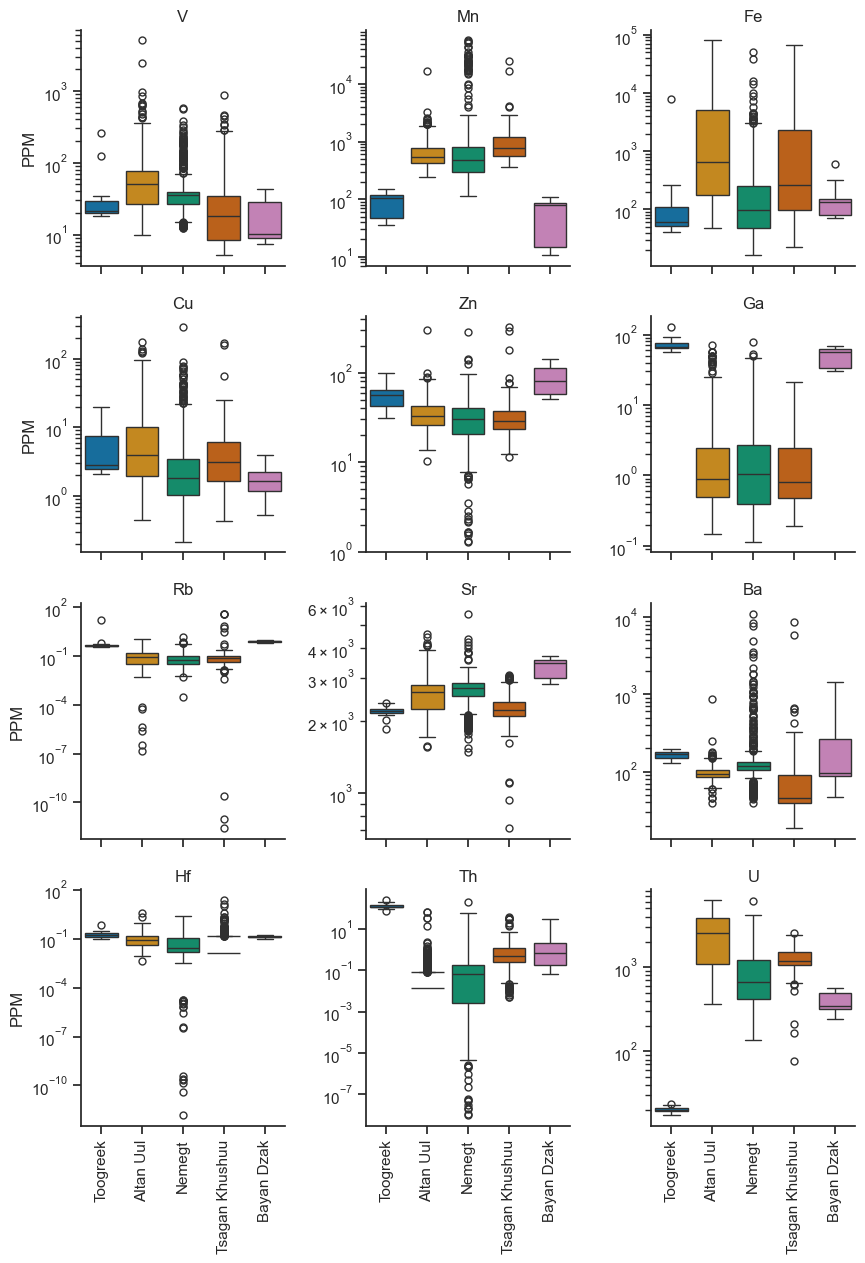

In [488]:
cp = sns.catplot(
    ppm_long_other, 
    x='Locality', 
    y='PPM', 
    col='Element', 
    col_wrap=3, 
    palette='colorblind', 
    log_scale=True, 
    hue='Locality',
    sharey=False,
    kind='box',
    height=3,
    aspect=1
)
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in cp.axes.flat]
cp.set(xlabel=None)
cp.set_titles('{col_name}')

In [489]:
cp.savefig('Plots/boxplots - Other elements.jpg', dpi=300)

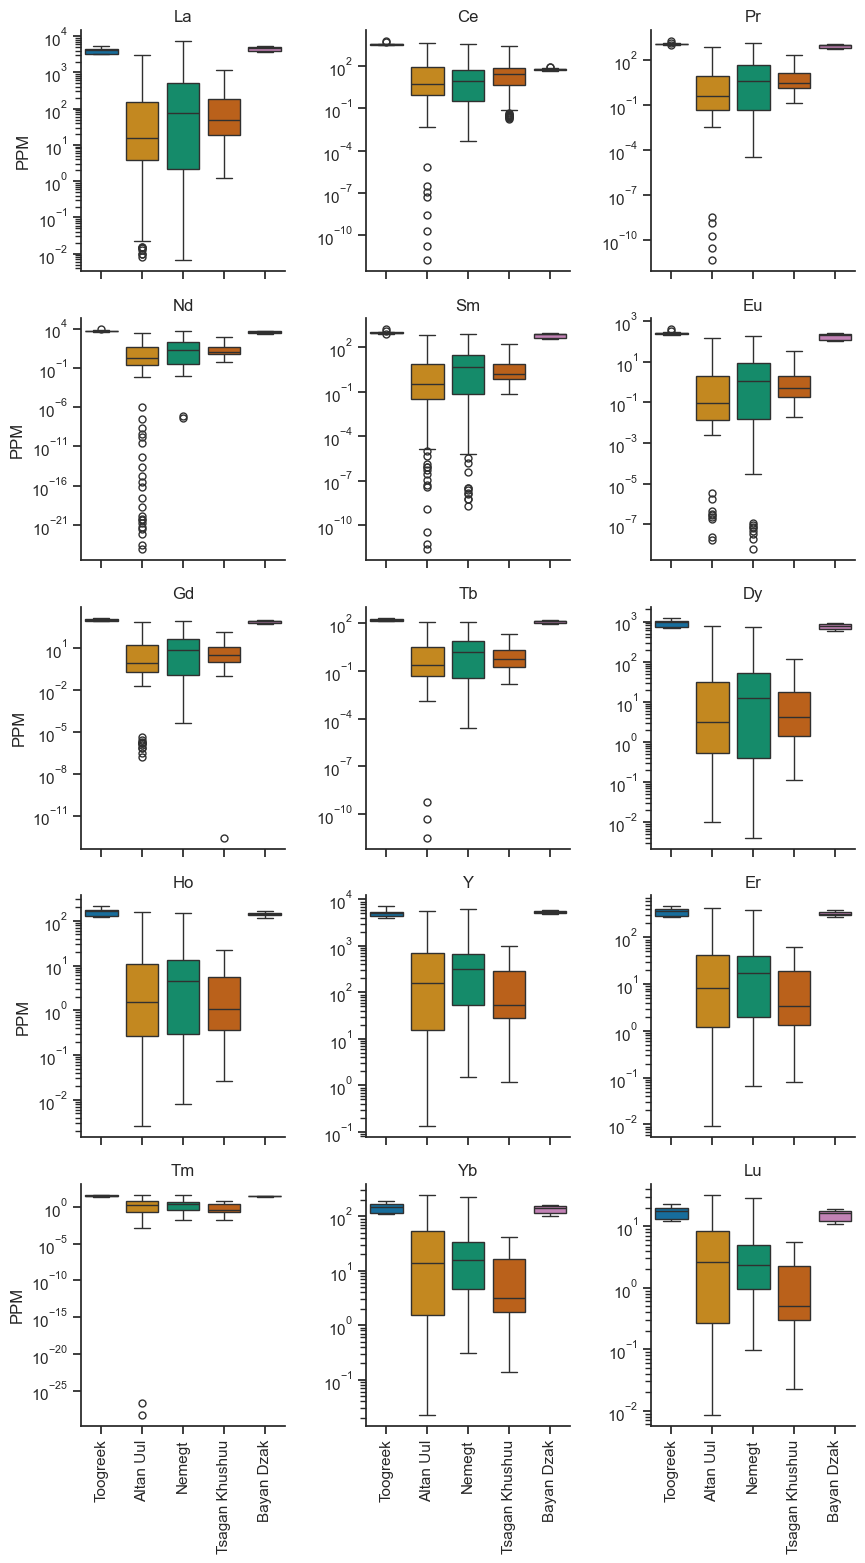

In [490]:
cp = sns.catplot(
    ppm_long_ree, 
    x='Locality', 
    y='PPM', 
    col='Element', 
    col_wrap=3, 
    palette='colorblind', 
    log_scale=True, 
    hue='Locality',
    sharey=False,
    kind='box',
    height=3,
    aspect=1,
    col_order = ree
)
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in cp.axes.flat]
cp.set(xlabel=None)
cp.set_titles('{col_name}')

In [493]:
cp.savefig('Plots/boxplots - REY.jpg', dpi=300)

## Ba and Sr

In [498]:
basr = ppm.loc[:, ['Ba', 'Sr']].merge(spot_info, left_index=True, right_index=True)

In [500]:
basr_long = basr.melt(id_vars=spot_info.columns, ignore_index=False, var_name='Var', value_name='Val')

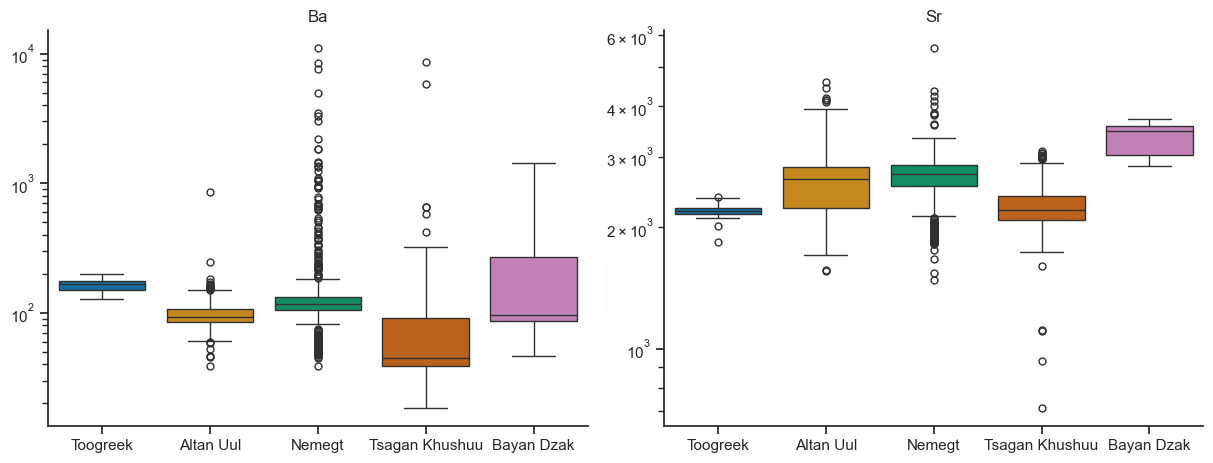

In [223]:
cp = sns.catplot(basr_long, y='Val', x='Locality', hue='Locality', log_scale=True, kind='box', col='Var', sharey=False, aspect=1.25)
cp.set_titles('{col_name}')
cp.set(xlabel='', ylabel='')

In [224]:
cp.savefig('Plots/Sr and Ba contents.png', dpi=300)

[Text(0.5, 0, ''), Text(0, 0.5, 'Ba/Sr')]

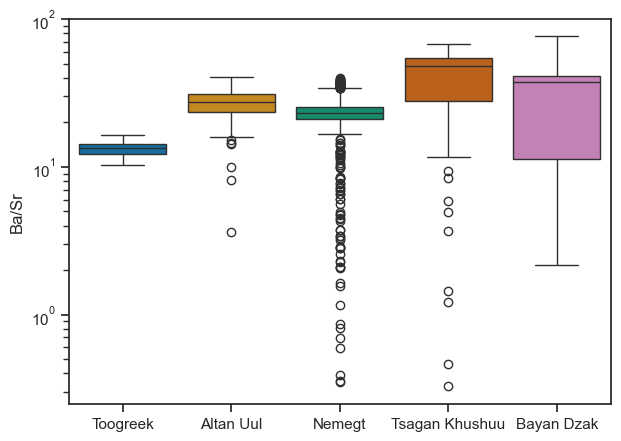

In [502]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=basr, x='Locality', y=basr.Sr/basr.Ba, hue='Locality', log_scale=True, ax=ax)
ax.set(xlabel='', ylabel='Ba/Sr')

In [504]:
fig.savefig('Plots/Sr-Ba ratio.jpg', dpi=300)

## HREE

In [228]:
hree = ppm.loc[:, ['Y', 'Tm', 'Yb', 'Ho']].merge(spot_info, left_index=True, right_index=True)

In [229]:
hree_long = hree.melt(id_vars=spot_info.columns, ignore_index=False, var_name='Var', value_name='Val')

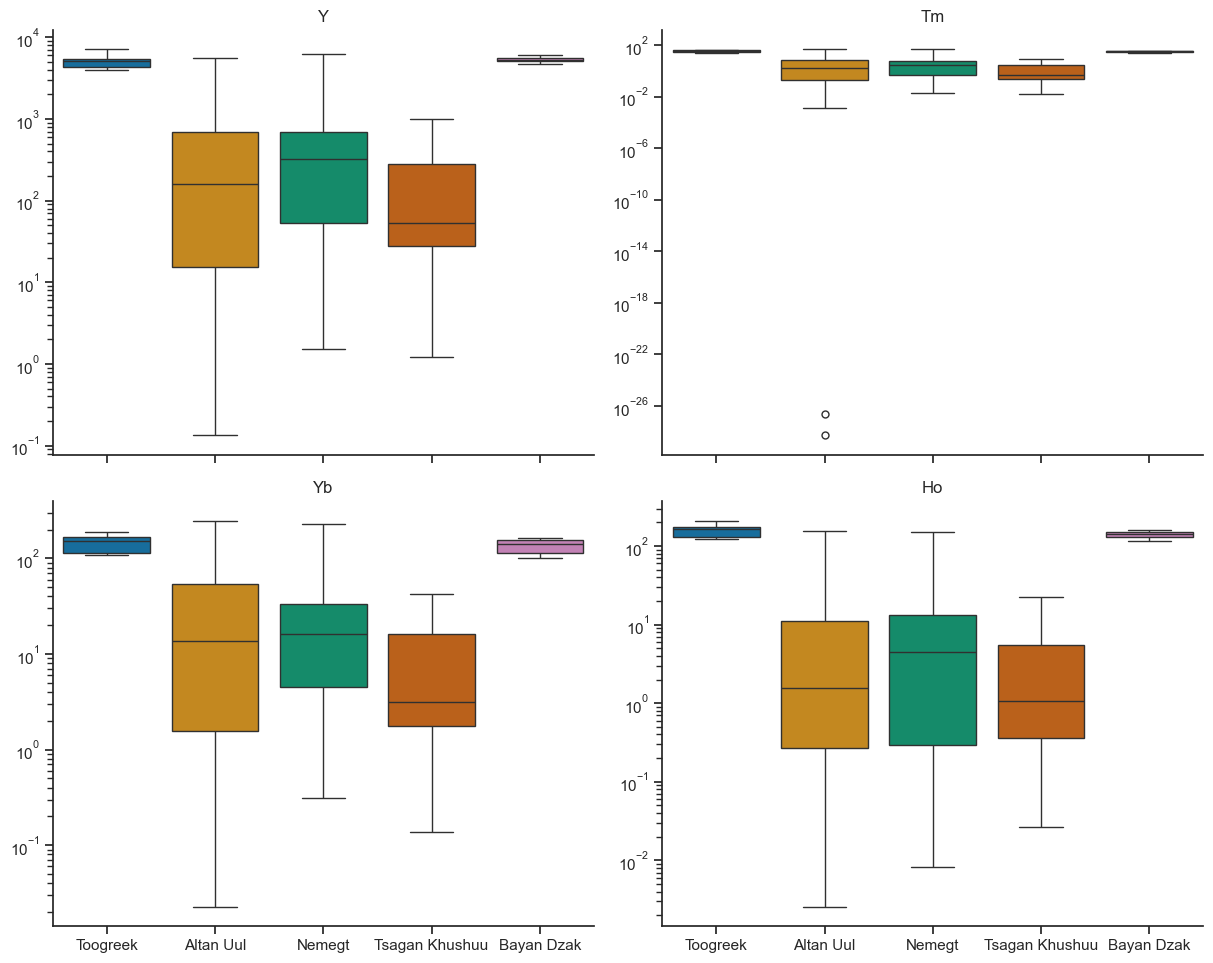

In [230]:
cp = sns.catplot(hree_long, y='Val', x='Locality', hue='Locality', log_scale=True, kind='box', col='Var', col_wrap=2, sharey=False, aspect=1.25)
cp.set_titles('{col_name}')
cp.set(xlabel='', ylabel='')

In [231]:
fig.savefig('Plots/HREE boxplots.tif', dpi=300)

## Mn and Fe

In [233]:
metox = ppm.loc[:, ['Mn', 'Fe']].merge(spot_info, left_index=True, right_index=True)

In [234]:
metox_long = metox.melt(id_vars=spot_info.columns, ignore_index=False, var_name='Var', value_name='Val')

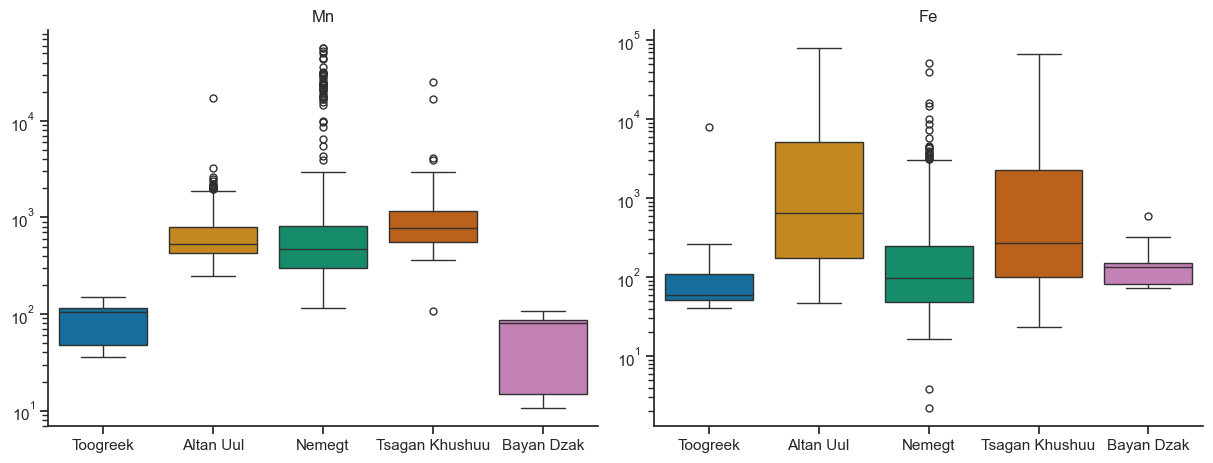

In [235]:
cp = sns.catplot(metox_long, y='Val', x='Locality', hue='Locality', log_scale=True, kind='box', col='Var', sharey=False, aspect=1.25)
cp.set_titles('{col_name}')
cp.set(xlabel='', ylabel='')

In [236]:
fig.savefig('Plots/Fe and Mn boxplots.tif', dpi=300)

[Text(0.5, 0, ''), Text(0, 0.5, 'Fe/Mn')]

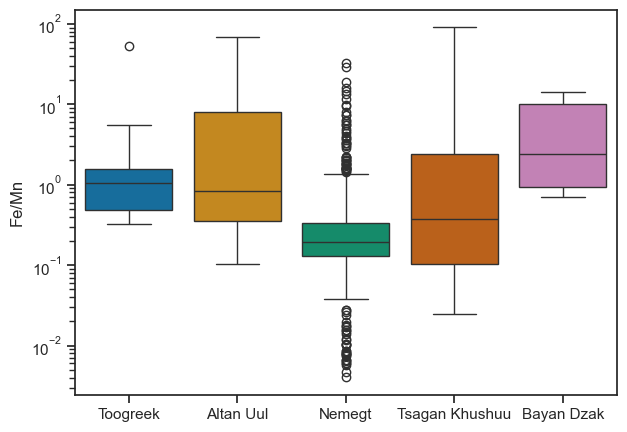

In [237]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=metox, x='Locality', y=metox.Fe/metox.Mn, hue='Locality', log_scale=True, ax=ax)
ax.set(xlabel='', ylabel='Fe/Mn')

In [238]:
fig.savefig('Plots/Mn-Fe ratio.tif', dpi=300)

## U and Th

In [506]:
uth = ppm.loc[:, ['U', 'Th']].merge(spot_info, left_index=True, right_index=True)

In [241]:
uth_long = uth.melt(id_vars=spot_info.columns, ignore_index=False, var_name='Var', value_name='Val')

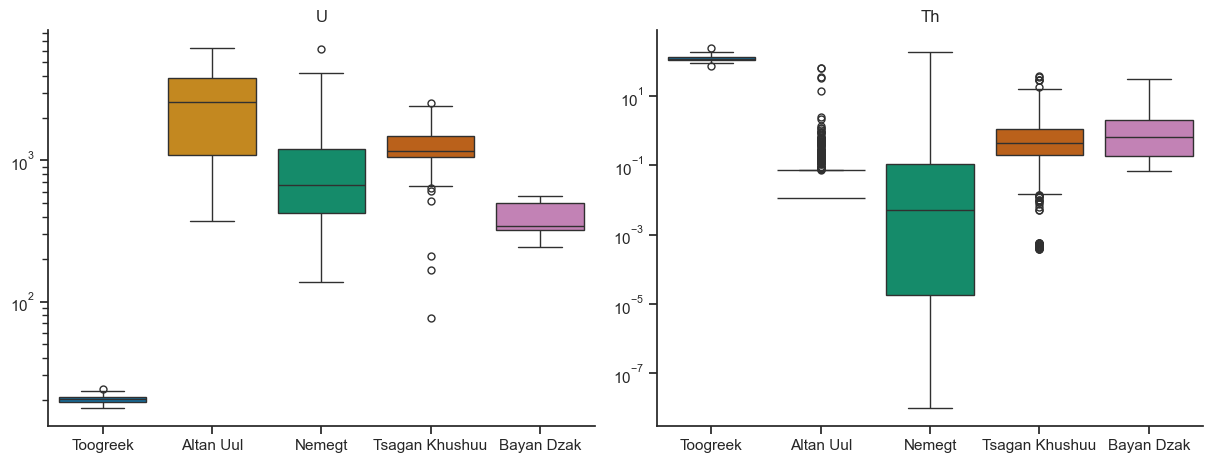

In [242]:
cp = sns.catplot(uth_long, y='Val', x='Locality', hue='Locality', log_scale=True, kind='box', col='Var', sharey=False, aspect=1.25)
cp.set_titles('{col_name}')
cp.set(xlabel='', ylabel='')

In [243]:
fig.savefig('Plots/U and Th boxplots.tif', dpi=300)

[Text(0.5, 0, ''), Text(0, 0.5, 'U/Th')]

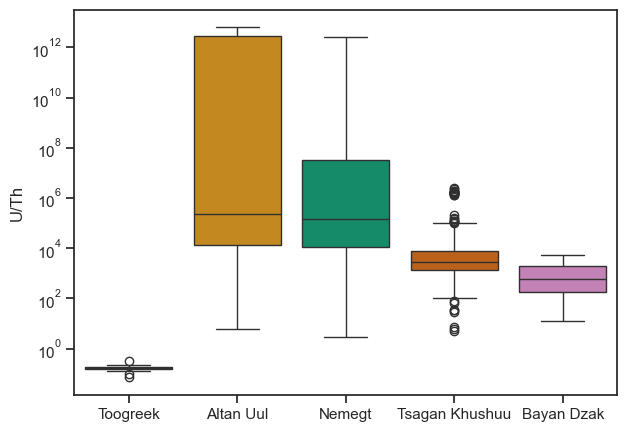

In [508]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=basr, x='Locality', y=uth.U/uth.Th, hue='Locality', log_scale=True, ax=ax)
ax.set(xlabel='', ylabel='U/Th')

In [510]:
fig.savefig('Plots/U-Th ratio.tif', dpi=300)

In [246]:
selected_others = ppm.loc[:, ['Ba', 'Sr', 'Mn', 'Fe', 'U', 'Th']].merge(spot_info, left_index=True, right_index=True)

In [247]:
selected_hree = ppm.loc[:, ['Ho', 'Y', 'Tm', 'Yb']].merge(spot_info, left_index=True, right_index=True)

In [248]:
selected_others = selected_others.melt(id_vars=spot_info.columns, ignore_index=False, var_name='Var', value_name='Val')

In [249]:
selected_hree = selected_hree.melt(id_vars=spot_info.columns, ignore_index=False, var_name='Var', value_name='Val')

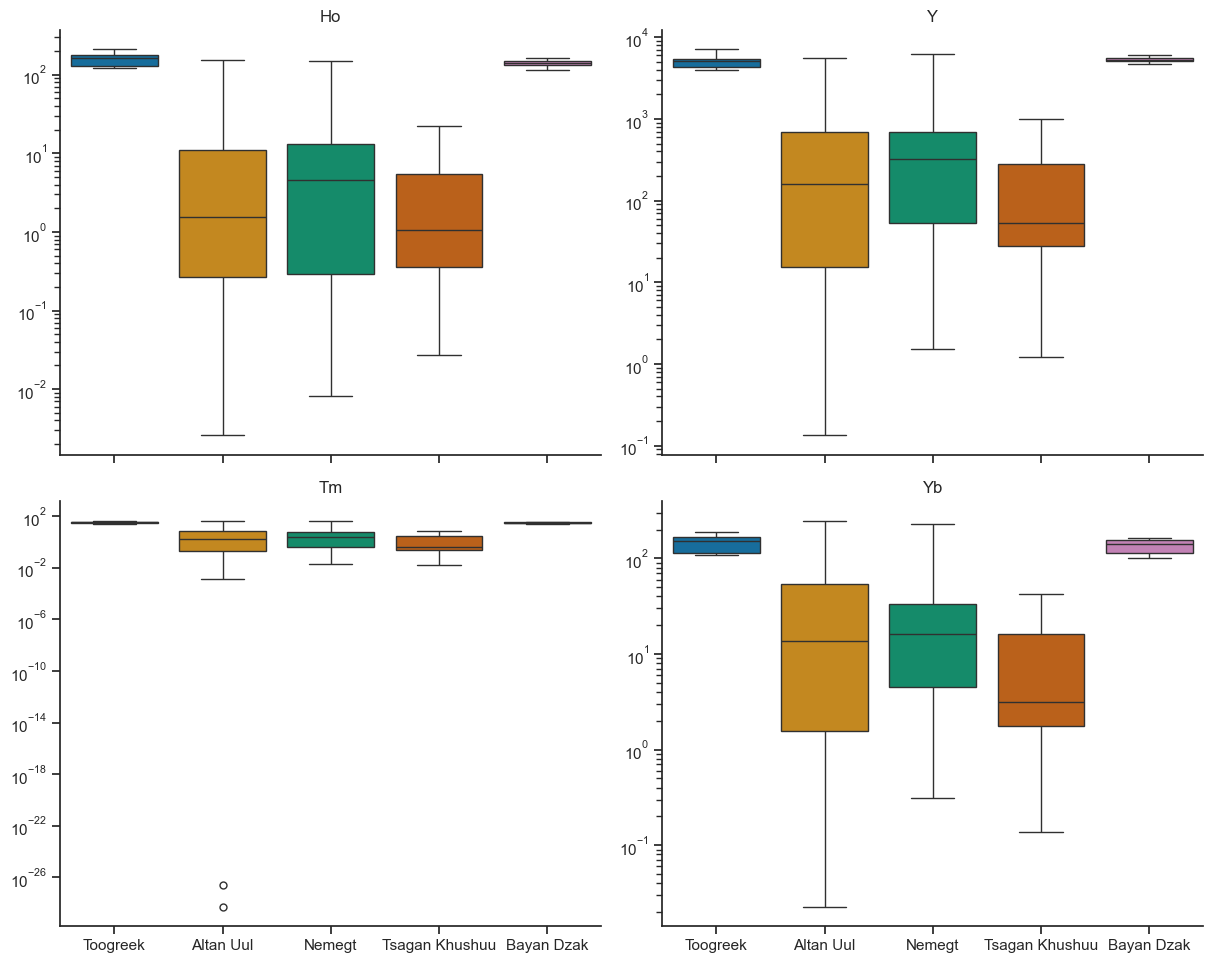

In [250]:
cp = sns.catplot(selected_hree, y='Val', x='Locality', hue='Locality', log_scale=True, kind='box', col='Var', col_wrap=2, sharey=False, aspect=1.25)
cp.set_titles('{col_name}')
cp.set(xlabel='', ylabel='')

In [251]:
cp.savefig('Plots/HREE boxplots.tif', dpi=300)

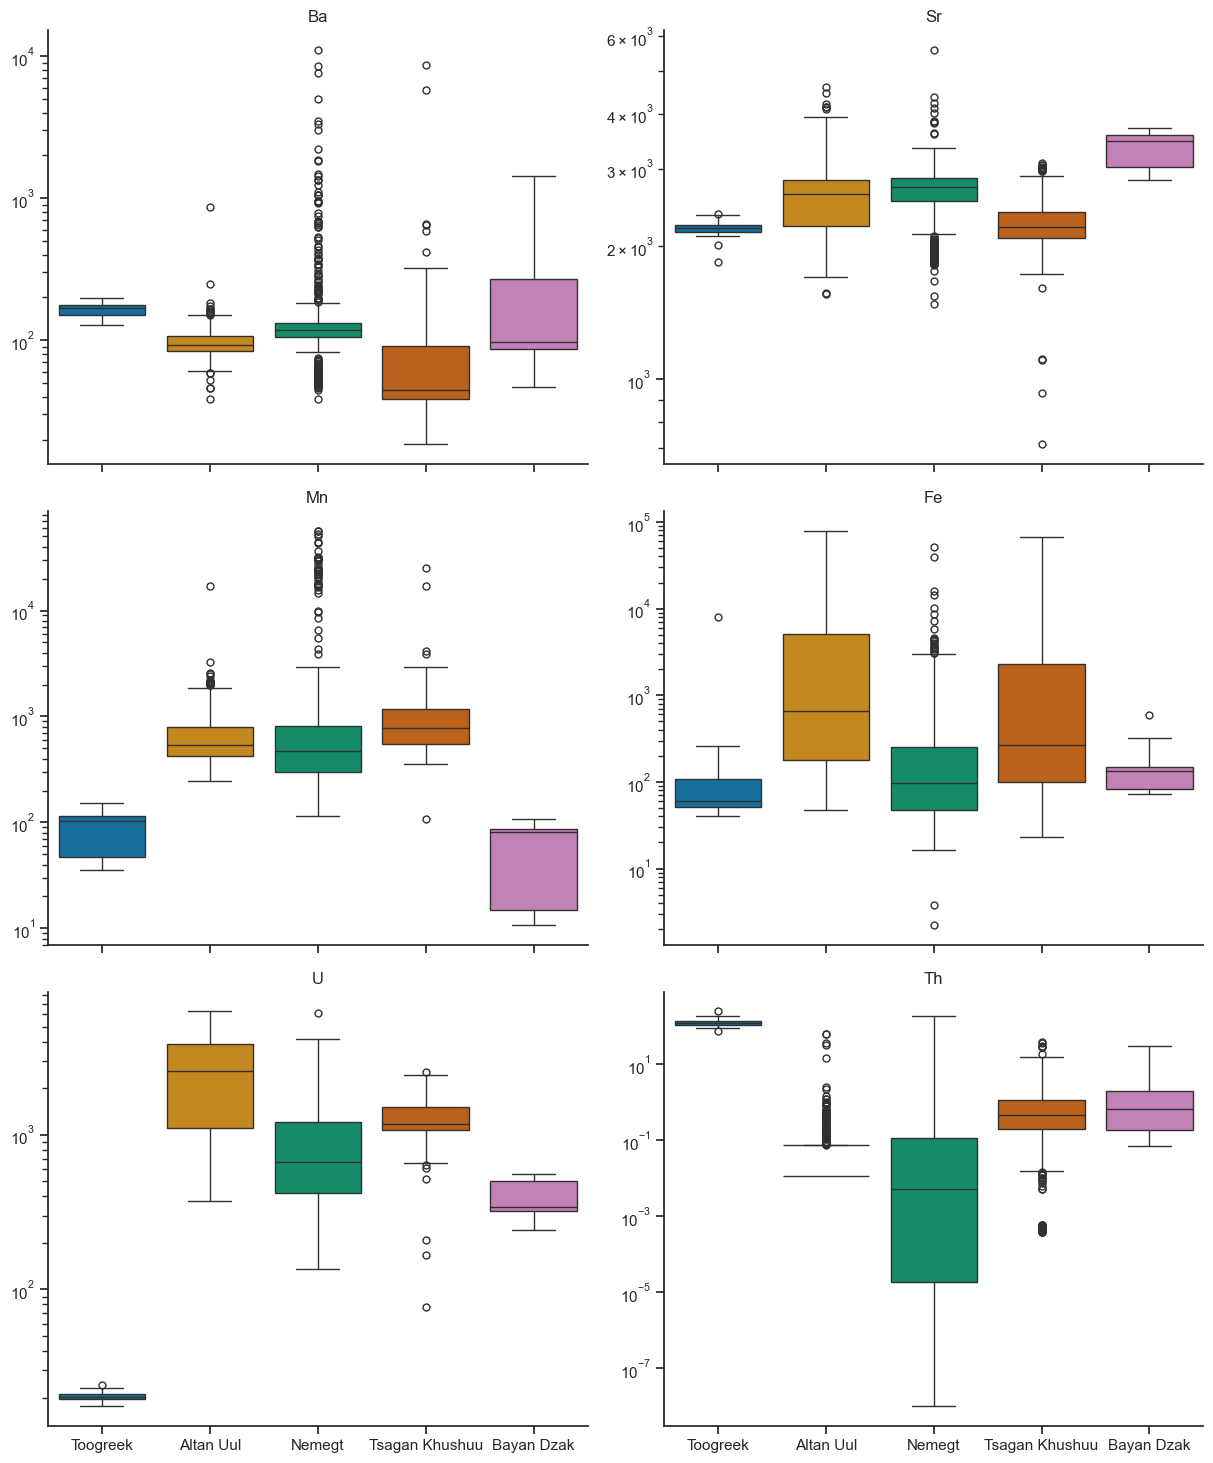

In [252]:
cp = sns.catplot(selected_others, y='Val', x='Locality', hue='Locality', log_scale=True, kind='box', col='Var', col_wrap=2, sharey=False, aspect=1.25)
cp.set_titles('{col_name}')
cp.set(xlabel='', ylabel='')

In [253]:
cp.savefig('Plots/Other elements boxplots.tif', dpi=300)

In [254]:
ppm_fullframe = ppm.merge(spot_info, left_index=True, right_index=True)

In [255]:
ppmData = ppm_fullframe.reset_index()
ppmData['SampleLine'] = ppmData.SampleID + '-' + ppmData.Line

In [256]:
ppmData.columns

Index(['SampleID', 'Line', 'Spot', 'SpotID', 'Ca', 'V', 'Mn', 'Fe', 'Cu', 'Zn',
       'Ga', 'Rb', 'Sr', 'Y', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd',
       'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Th', 'U', 'SpecimenID',
       'Genus', 'Locality', 'Bone', 'tissueType', 'mmDist', 'maxDist',
       'profilePerc', 'Other comm', 'SampleLine'],
      dtype='object')

In [257]:
ppmData = ppmData.loc[:, ['SampleID', 'Line', 'Spot', 'SpotID', 'SampleLine', 
                          'V', 'Mn', 'Fe', 'Cu', 'Zn', 'Ga', 'Rb', 'Sr', 'Y',
                          'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb',
                          'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Th', 'U', 
                          'SpecimenID', 'Genus', 'Locality', 'Bone', 'tissueType', 
                          'mmDist', 'profilePerc']]

In [258]:
elements_analyzed = ['V', 'Mn', 'Fe', 'Cu', 'Zn', 'Ga', 'Rb', 'Sr', 'Y', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Th', 'U']

# Profiles of all elements

In [271]:
locs_order = 'Nemegt', 'Altan Uul', 'Tsagan Khushuu', 'Toogreek', 'Bayan Dzak'

In [272]:
locs_array = np.array([['Nemegt', 'Altan Uul', 'Tsagan Khushuu'], ['Toogreek', 'Bayan Dzak', None]])

Code below is to generate interactive plotly plot with profiles of all elements. The notebook takes a lot of time to process the code when it is active, so it remains inactive.

In [286]:
def count_fig_axes(plotly_fig, x=True, y=True):

    answer = {}
    
    if x:
        xaxes = 0
        for kword in plotly_fig.layout:
            if kword.startswith('xaxis'):
                xaxes += 1
        answer['x'] = xaxes
    if y:
        yaxes = 0
        for kword in plotly_fig.layout:
            if kword.startswith('yaxis'):
                yaxes += 1
        answer['y'] = yaxes
    return answer

#%% Element profiles

# create the figure with subplots for 5 localities (6th plot is empty)
plotly_fig = make_subplots(rows=2, cols=3, shared_xaxes='all', shared_yaxes='all', subplot_titles=locs_order, vertical_spacing=0.1, horizontal_spacing=0.05)

# code for the buttons of the element selection
steps_dict = {}
steps_back = 0
visibility = True

for element in elements_analyzed:
    ### iterate over elements
    ### from the table select only the columns with:
    ###  - an element of interest
    ###  - distance - that is, X-data
    ###  - sample and spot information (sample ID, spot no, profile, specimen)
    ###  - bone and locality
    frame = ppmData.loc[:, [element, 'SampleID', 'SpecimenID', 'mmDist', 'Bone', 'Locality', 'SampleLine', 'Spot']]
    frame.dropna(subset=element, inplace=True)
    step_vals = []

    for loc in locs_array.flatten():
        ### iteration over localitites
        
        if loc: # if locality is not NONE
            row, col = np.where(locs_array == loc)
            row, col = row[0] + 1, col[0] + 1
            
            frame_loc = frame[frame.Locality == loc]
            slines = frame_loc['SampleLine'].unique()

                        
            for sline in slines:
                ### iteration over sample-lines/profiles
                ### each profile is a trace added to the relevant plot
                frame_sline = frame_loc[frame_loc.SampleLine == sline]
 
                plotly_fig.add_trace(
                    go.Scatter(
                        visible=visibility,
                        mode='lines+markers',
                        x=frame_sline['mmDist'],
                        y=frame_sline[element],
                        text=[element] * len(frame_sline), # to ensure that each spot on the plot has `text` value equal to the name of an element
                        name=sline,
                        customdata=frame_sline[['SampleID', 'SampleLine', 'Spot', 'Bone', 'SpecimenID']]
                    ),
                    row=row,
                    col=col
                )
                step_vals.append(True)
        else: # if locality IS NONE
            continue
    
    # the code below is to ensure that the buttons related to the elements work properly and display selected element
    # the logic is to create a list of boolean values, where all values are FALSE,
    # except for the ones referring to the element selected from the button
    this_step = [False] * steps_back + step_vals + [False] * (1508 - (steps_back + len(step_vals))) # steps_back = elements_analyzed (that is - features) * no of samplelines (53)
    steps_dict[element] = this_step
    steps_back += len(step_vals)
    visibility = False



### code for selection of the elements
buttons = []

for elem, active_traces in steps_dict.items():
    button = dict(
        label=str(elem),
        method="restyle",
        args=["visible", active_traces]
    )
    buttons.append(button)

# count axes and set data for buttons switching between linear and logarithmic scale
ax_num = count_fig_axes(plotly_fig, x=False)['y'] - 1
args_lin = dict(zip([f'yaxis.type' if i == 0 else f'yaxis{i + 1}.type'for i in range(ax_num)], ['linear'] * ax_num))
args_log = dict(zip([f'yaxis.type' if i == 0 else f'yaxis{i + 1}.type'for i in range(ax_num)], ['log'] * ax_num))

### buttons to switch between linear and logarithmic scale
plotly_fig.update_layout(
    updatemenus=[
        dict(
            type='buttons', 
            buttons=buttons,
            showactive=True,
            x=-0.05,
            y=1,
            xanchor="center",
            yanchor="top",
            direction='down'),
        {
        'type' : 'buttons',
        'buttons' : [{
            'label' : 'Linear scale',
            'method' : 'relayout',
            'args' : [args_lin]
        },
        {
            'label' : 'Logscale',
            'method' : 'relayout',
            'args' : [args_log]
        }],
            'direction' : 'right',
            'x' : 0,
            'y' : 1.075,
            'xanchor' : 'left',
            'yanchor' : 'top'
    }
        
        ],
    width=1800,
    height=1200, 
    showlegend=False
)

                         
plotly_fig.update_traces(hovertemplate=
                         '<b>%{customdata[0]}</b><br>' +
                         '<i>%{customdata[1]}-%{customdata[2]}</i><br>' +
                         '<i>%{customdata[4]}</i><br>' +
                         'Bone: <b>%{customdata[3]}</b><br>' + 
                         'Distance: <b>%{x} mm</b><br>' + 
                         '%{text}: ' +'<b>%{y}</b>'+
                         "<extra></extra>")

plotly_fig.update_xaxes(range=(0, 40))
plotly_fig.update_yaxes(range=(-300, 5300))
plotly_fig.write_html('Plots\\Element profiles.html', default_width=2100, default_height=1400)

In [275]:
ppmData.columns

Index(['SampleID', 'Line', 'Spot', 'SpotID', 'SampleLine', 'V', 'Mn', 'Fe',
       'Cu', 'Zn', 'Ga', 'Rb', 'Sr', 'Y', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Sm',
       'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Th', 'U',
       'SpecimenID', 'Genus', 'Locality', 'Bone', 'tissueType', 'mmDist',
       'profilePerc'],
      dtype='object')

In [276]:
df = ppm.merge(spot_info, left_index=True, right_index=True)

In [277]:
df['Profile'] = df.index.get_level_values(0) + '-' + df.index.get_level_values(1)

In [278]:
ppmData.sort_values(['Locality', 'SampleID', 'Line', 'mmDist'], inplace=True)

In [279]:
all_profiles = PdfPages('All profiles.pdf')

for element in elements_analyzed:
    g = sns.relplot(df, 
                    x='mmDist',
                    y=element,
                    hue='Profile',
                    col='Locality',
                    col_wrap=3,
                    facet_kws=dict(sharex=False, sharey=False),
                    style='Profile').set(yscale='log', ylabel='Distance [mm]')
    sns.move_legend(g, loc='center left', ncols=3, title='Profile', bbox_to_anchor=(0.64, 0.27), fontsize='small')
    all_profiles.savefig(g.figure)
    plt.close()
all_profiles.close()